***Problem Statement:***

A car insurance expert center is working every day from 8 am to 6 pm. The door of the center is closed at 6:00 p.m. and only the cars that are inside the center until that moment are served until the system is empty. After the end of the working hours of the center every day, if there is a queue outside the premises, it will also disappear. In order to investigate and carry out the necessary measures, both cars (the culprit and the complainant) must be present at the same time. If one of the cars entered before the closing of the center, the second car can also enter after 6:00 PM. It is a function of snowfall and rain and the time period of arrival. Historical data shows that the distribution of arrival of clients is different in the hours of 8-10, 10-13, 13-15, and 15-18.

After entering the insurance center, if the cars have entered in pairs, if there is capacity, they will immediately enter the queue for taking photos. 2 photographers are present in the photography center, and the time distribution of each of them taking pictures of a pair of cars follows an exponential distribution with an average of 6 minutes. The queue of the photo taking area has a limited capacity of 40 cars (20 pairs of cars) and if the queue capacity is full, the cars must wait outside the insurance area until the queue capacity is empty for them. Based on historical data, 30% of clients arrive at the insurance center individually and have to wait for a second car. If these clients have the possibility to enter the queue for taking photos inside the area, according to the insurance law, they will first be taken to the waiting parking area. After the arrival of the second car, to enter the photo queue inside the area, these cars have priority over the cars outside the photo area. If a single car has entered the queue outside the area and remains in the same queue until the arrival of the second car, the second car will be added to the queue outside the area right behind the first car. The waiting time of a single car until its pair arrives follows an exponential distribution with a mean of 30 minutes.

After the end of taking photos, the cars enter the filing department. The distance from each section to another section is assumed to be insignificant. In this part, 3 experts are working with triangular service distribution with minimum, average and maximum of 5, 6 and 7 minutes respectively. After the filing stage, the cars enter the expert queue, where 2 experts serve with an exponential distribution with an average of 9 minutes. After the examination, the review process will be different depending on whether the clients intend to file a complaint or not. If the cars do not intend to file a complaint, after the expert stage, they must enter the filing section again and complete the file. In this section, the cars that complete the case have priority over the cases that are filed. The duration of the case completion in the second part follows the probability distribution D1. Based on historical data, 10% of the clients of this center complain. For this purpose, after the expert stage, the cars enter the complaint registration department, where an expert is working. The duration of complaint processing has an exponential distribution with an average of 15 minutes. After filing the complaint, the cars must go through expert procedures again and then complete the case. (The service distribution of these two departments will not be different for the clients who come from the complaint registration.) Finally, after completing the case, the cars will leave the insurance center. Below is the outline of the center's processes.



***Part one:***

In this section, the libraries considered for this project are added to the code. Also, random number generation functions with different distributions are also made.


In [ ]:
#First, we import the required libraries
import random as rnd
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#The following functions generate random values in exponential and triangular distributions
def triangular(l,m,h):
    """
    This function generates a random number with triangular distribution.
    """
    r = rnd.random()
    if r < (m-l)/(h-l) :
        return math.sqrt(r*(h-l)*(m-l))+l
    elif r >= (m-l)/(h-l) :
        return h - math.sqrt((1-r)*(h-m)*(h-l))

def exponential(lambd):
    """
    This function generates a random number with exponential distribution.
    """
    r = rnd.random()
    return -(1 / lambd) * math.log(r)



The following function is written to search for a specific ID in a list.
If there is an id in the list, its house number, and if it is not there, the value of False will be the output of the function


In [ ]:
def search_id(id , l):
  """
  This function finds the location of each customer in each queue with the help of that customer's ID.
  """
  result = False
  for i in range(0 , len(l)):
    if l[i]["id"] == id:
      result = i
  return result

***Part two:***

The following class is actually an insurance center simulation. This class receives queue capacity, the number of operators in each section and center probabilities as inputs.
This class has 2 main outputs that are used to analyze the results.

data_frame: This dataframe contains all the main values. Each line also represents an event that happened in the system. There is also customer information that the event is related to in each line.
Note 1: Considering that the entry event from outside to inside is not related to a specific customer, its ID value is none.
Note 2: When the time is after 18:00, the value of the variable (the actual value of smooth outside) will be equal to none.

waiting_df: This data frame shows the entry and exit time of each customer to each queue. With the help of this data frame, the waiting time of each customer in each queue can be calculated.
In cases where the customer has not entered a queue, the entry and exit values will be none.
Also, in some cases (such as the queue of even number of cars in the parking lot), the time of entering and leaving the parking lot are equal.


In [ ]:
class insurance_center:
    """
    This class is an insurance center simulator.
    There are various functions in this class. Some are for advancing the simulation and some are for outputting and inputting data.
    """
    def __init__(self , param_type_proportion  , param_Complaining ,
                 photo_cap , photo_server , document_server , expert_server , complaint_server ):
        """
        In this function, the initial values of the simulation parameters are defined.
        param_type_proportion: The probability that the car entering the system is single
        param_Complaining: The probability that the customer who enters the system intends to complain.
        photo_cap: The capacity of the photo queue
        photo_server: The number of operators who serve in the photography department.
        document_server: The number of operators who serve in the document department.
        expert_server: The number of operators who serve in the expert department.
        complaint_server: The number of operators who serve in the complaint department.
        """
        self.data = dict()
        self.state = dict()
        self.future_event_list = list()
        self.param_type_proportion = param_type_proportion #0.3
        self.param_Complaining = param_Complaining #0.1

        #ndicates the clock in the simulation
        self.clock = 0

        self.sorted_fel = None
        self.current_event = None
        self.customer = dict()
        self.ques = dict()

        self.photo_cap = photo_cap #20
        self.photo_server = photo_server #2
        self.document_server = document_server #3
        self.expert_server = expert_server #2
        self.complaint_server = complaint_server #1

        #Customer ID
        self.id = 0

        self.end_of_sim = False

        self.table = list()

        self.day = 0

    """
    The following functions are used to generate random values with a given distribution and parameter.
    """
    def S_photo(self):
      return exponential(1/6)

    def S_formation(self):
      return triangular(5,6,7)

    def S_expert(self):
      return exponential(1/9)

    def S_completion(self):
      return triangular(6,8,9)

    def S_complaint(self):
      return exponential(1/15)

    def S_single(self):
      return exponential(1/30)

    def S1(self , type_of_day):
      if type_of_day == "rainy":
        return exponential(1/1)
      if type_of_day == "normal":
        return exponential(1/2)

    def S2(self , type_of_day):
      if type_of_day == "rainy":
        return exponential(1/0.5)
      if type_of_day == "normal":
        return exponential(1/3)

    def S3(self , type_of_day):
      if type_of_day == "rainy":
        return exponential(1/4)
      if type_of_day == "normal":
        return exponential(1/5)

    def S4(self , type_of_day):
      if type_of_day == "rainy":
        return exponential(1/2)
      if type_of_day == "normal":
        return exponential(1/3)

    def type_of_day_maker(self):
      """
      This function randomly determines the type of day.(rainy or normal)
      """
      r = rnd.random()
      if r > 0.31:
        return("normal")
      if r <= 0.31:
        return("rainy")




    def data_def(self):
        """
        This function defines the lists and dictionaries that are needed for data storage.
        """
          #To store the entry and exit time of each customer from each queue
        #{id:[enter , exit]}

        self.waitting = dict()
        self.waitting['Out Queue'] = dict()
        self.waitting['Photo Queue'] = dict()
        self.waitting['Expert Queue'] = dict()
        self.waitting['Document Completion Queue'] = dict()
        self.waitting['Complaint Queue'] = dict()
        self.waitting['Document formation Queue'] = dict()
        self.waitting['Single Cars in Parking'] = dict()
        self.waitting['Double Cars in Parking'] = dict()
        self.waitting['day'] = 0




    def starting_state(self):
        """
        This function determines the initial conditions for starting the simulation.
        """

        # State variables of Queues
        self.state['Out Queue'] = 0
        self.state['Photo Queue'] = 0
        self.state['Document formation Queue'] = 0
        self.state['Expert Queue'] = 0
        self.state['Document Completion Queue'] = 0
        self.state['Complaint Queue'] = 0
        # State variables of servers
        self.state['Photo Server'] = 0
        self.state['Document Server'] = 0
        self.state['Expert Server'] = 0
        self.state['Complaint Server'] = 0
        # State variables of Parking
        self.state['Single Cars in Parking'] = 0
        self.state['Double Cars in Parking'] = 0


        #The following lists store the information of the customers who are in each queue at that moment.
        self.ques['Out Queue'] = [{"id" : -1 , "type" : None}]
        self.ques['Photo Queue'] = list()
        self.ques['Document formation Queue'] = list()
        self.ques['Expert Queue'] = list()
        self.ques['Document Completion Queue'] = list()
        self.ques['Complaint Queue'] = list()
        self.ques['Single Cars in Parking'] = [{"id" : 0 , "type" : None}]
        self.ques['Double Cars in Parking'] = list()

        #The actual number of people in outside queue

        self.realoutque = {"time" : [] , "outquelength" : []}







        # FEL initialization, and Starting events that initialize the simulation
        #self.future_event_list.append({'Event Type': 'start', 'Event Time': 0, 'customer': ''})

        #{id  : id , type : single or double ,complaint:  0 or 1 ,work:  0 or 1}
        self.future_event_list = list()
        c = self.customer_maker()
        self.future_event_list.append({'Event Type': 'Arrival insurance', 'Event Time': 480, 'customer': c })
        self.future_event_list.append({'Event Type': 'Event 18', 'Event Time': 1080 , 'customer': None })


    def fel_maker(self, event_type: str, customer: None , type_of_day = None ):
      """
      This function is supposed to set the next event into future event list
      future_event_list: list that contains all future events
      param event_type: types of each event that can occur in this simulation
      clock: Simulation clock
      param customer: A dict that filled with each user's attributes
      param type_of_day: The day type is stored in this variable

      """

      if event_type == 'Arrival insurance':
        if type_of_day == "normal":
          if 480 <= self.clock  <= 600:
            event_time = self.clock + self.S1("normal")
          elif 600 < self.clock  <= 780:
            event_time = self.clock + self.S2("normal")
          elif 780 < self.clock  <= 900:
            event_time = self.clock + self.S3("normal")
          elif 900 < self.clock  <= 1080:
            event_time = self.clock + self.S4("normal")


        elif type_of_day == "rainy":
          if 480 <= self.clock  <= 600:
            event_time = self.clock + self.S1("rainy")
          elif 600 < self.clock  <= 780:
            event_time = self.clock + self.S2("rainy")
          elif 780 < self.clock  <= 900:
            event_time = self.clock + self.S3("rainy")
          elif 900 < self.clock  <= 1080:
            event_time = self.clock + self.S4("rainy")




      elif event_type == 'Arrival single vehicle':
        event_time = self.clock + self.S_single()

      elif event_type == 'Arrival frome outside to inside':
        event_time = self.clock

      elif event_type == 'End of photography':
        event_time = self.clock + self.S_photo()

      elif event_type == 'End of document formation':
        event_time = self.clock + self.S_formation()

      elif event_type == 'End of document completion':
        event_time = self.clock + self.S_completion()

      elif event_type == 'End of expert checking':
        event_time = self.clock + self.S_expert()

      elif event_type == 'End of complaint':
        event_time = self.clock + self.S_complaint()

      elif event_type == 'End of simulation':
        event_time = self.clock

      if event_type == 'Arrival insurance' and event_time>1080:
        pass

      else:
        new_event = {'Event Type': event_type, 'Event Time': event_time, 'customer': customer}
        self.future_event_list.append(new_event)




    def customer_maker(self):
      """
      This function randomly generates a customer with its features.
      {id  : id , type : S(sinle) or D(double) ,  complaint: 1(yes) or 0(no),  work:  1(yes) or 0(no)}

      """
      rnd1 = rnd.random()
      rnd2 = rnd.random()
      self.id +=1 #Create a new ID
      if  rnd1 > self.param_type_proportion:
        if rnd2 > self.param_Complaining:
          return({"id"  : self.id , "type" : "D" ,"complaint":  0 ,"work":  0})

        if rnd2 <= self.param_Complaining:
          return({"id"  : self.id  , "type" : "D" ,"complaint":  1 ,"work":  0})

      else:
        if rnd2 > self.param_Complaining:
          return({"id"  : self.id  , "type" : "S" ,"complaint":  0 ,"work":  0})

        if rnd2 <= self.param_Complaining:
          return({"id"  : self.id  , "type" : "S" ,"complaint":  1 ,"work":  0})



    def  Arrival_insurance(self):

      if self.clock <= 1080:
        if self.customer["type"] == "D":
          if self.state["Out Queue"] > 0:
            self.state["Out Queue"] += 1
            self.ques['Out Queue'].append(self.customer)
            self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

            id = str(self.customer["id"])
            self.waitting['Out Queue'][id] = [None , None ]
            self.waitting['Out Queue'][id][0] = self.clock


          elif self.state["Out Queue"] == 0:
            if self.state["Photo Queue"] == 0:
              if self.state["Photo Server"] == self.photo_server:
                self.state["Photo Queue"] += 1
                self.ques['Photo Queue'].append(self.customer)
                self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )


                id = str(self.customer["id"])
                self.waitting['Photo Queue'][id] = [None , None ]
                self.waitting['Photo Queue'][id][0] = self.clock





              elif self.state["Photo Server"] < self.photo_server:
                self.state["Photo Server"] += 1
                self.fel_maker('End of photography' , self.customer , None )
                self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )



            elif self.state["Photo Queue"] < self.photo_cap:
              self.state["Photo Queue"] +=1
              self.ques['Photo Queue'].append(self.customer)
              self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

              id = str(self.customer["id"])
              self.waitting['Photo Queue'][id] = [None , None ]
              self.waitting['Photo Queue'][id][0] = self.clock


            elif self.state["Photo Queue"] == self.photo_cap:
              self.state["Out Queue"] += 1
              self.ques['Out Queue'].append(self.customer)
              self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

              id = str(self.customer["id"])
              self.waitting['Out Queue'][id] = [None , None ]
              self.waitting['Out Queue'][id][0] = self.clock





        elif self.customer["type"] == "S":
          if self.state["Out Queue"] == 0:
            self.state['Single Cars in Parking'] += 1
            self.ques['Single Cars in Parking'].append(self.customer)
            self.fel_maker('Arrival single vehicle' , self.customer , None )

            self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

            id = str(self.customer["id"])
            self.waitting['Single Cars in Parking'][id] = [None , None ]
            self.waitting['Single Cars in Parking'][id][0] = self.clock



          elif self.state["Out Queue"] > 0:
            self.state['Out Queue'] += 1
            self.ques['Out Queue'].append(self.customer)
            self.fel_maker('Arrival single vehicle' , self.customer , None )
            self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

            id = str(self.customer["id"])
            self.waitting['Out Queue'][id] = [None , None ]
            self.waitting['Out Queue'][id][0] = self.clock



      else:
        pass


    def Arrival_single_vehicle(self):

      if search_id(self.customer["id"] , self.ques['Single Cars in Parking']) == False:
        if search_id(self.customer["id"] , self.ques['Out Queue']) == False:
          pass


        else:
          i = search_id(self.customer["id"] , self.ques['Out Queue'])
          self.ques['Out Queue'][i]["type"] = "D"

      else:
        self.state['Single Cars in Parking'] -= 1
        self.state['Double Cars in Parking'] += 1
        i = search_id(self.customer["id"] , self.ques['Single Cars in Parking'])


        id = str(self.customer["id"])
        self.waitting['Single Cars in Parking'][id][1] = self.clock

        self.waitting['Double Cars in Parking'][id] = [None , None ]
        self.waitting['Double Cars in Parking'][id][0] = self.clock

        self.ques['Double Cars in Parking'].append(self.ques['Single Cars in Parking'][i])
        del self.ques['Single Cars in Parking'][i]
        self.ques['Double Cars in Parking'][-1]["type"] = "D"

        if self.state['Photo Server'] == self.photo_server:
          if self.state['Photo Queue'] == self.photo_cap:
            pass

          elif self.state['Photo Queue'] < self.photo_cap:
            self.state['Photo Queue'] += 1
            self.state['Double Cars in Parking'] -= 1

            id = str(self.ques['Double Cars in Parking'][0]["id"])
            self.waitting['Double Cars in Parking'][id][1] = self.clock

            self.waitting['Photo Queue'][id] = [None , None ]
            self.waitting['Photo Queue'][id][0] = self.clock

            self.ques['Photo Queue'].append(self.ques['Double Cars in Parking'][0])
            del self.ques['Double Cars in Parking'][0]

        elif self.state['Photo Server'] < self.photo_server:
          self.state['Double Cars in Parking'] -= 1
          self.state['Photo Server'] += 1

          id = str(self.ques['Double Cars in Parking'][0]["id"])
          self.waitting['Double Cars in Parking'][id][1] = self.clock

          self.fel_maker('End of photography' , self.ques['Double Cars in Parking'][0] , None )
          del self.ques['Double Cars in Parking'][0]


    def Arrival_frome_outside_to_inside(self):
      if self.state['Photo Queue'] == self.photo_cap:
        pass

      elif self.state['Photo Queue'] < self.photo_cap:
        if self.state['Double Cars in Parking'] ==0:
          if  self.state["Out Queue"] == 0:
            pass

          elif self.state["Out Queue"] > 0:
            if self.ques['Out Queue'][1]['type']=='S':
              self.state["Out Queue"]-= 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Out Queue'][id][1] = self.clock

              self.state['Single Cars in Parking'] += 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Single Cars in Parking'][id] = [None , None ]
              self.waitting['Single Cars in Parking'][id][0] = self.clock

              self.ques['Single Cars in Parking'].append(self.ques['Out Queue'][1])
              del self.ques['Out Queue'][1]
              self.fel_maker('Arrival frome outside to inside' , None , None )

            elif self.ques['Out Queue'][1]['type']=='D':
              self.state['Photo Queue']+= 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Photo Queue'][id] = [None , None ]
              self.waitting['Photo Queue'][id][0] = self.clock


              self.state["Out Queue"]-= 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Out Queue'][id][1] = self.clock

              self.ques['Photo Queue'].append(self.ques['Out Queue'][1])
              del self.ques['Out Queue'][1]

              self.fel_maker('Arrival frome outside to inside' , None , None )

        elif self.state['Double Cars in Parking'] > 0:
          self.state['Double Cars in Parking'] -= 1

          id = str(self.ques['Double Cars in Parking'][0]["id"])
          self.waitting['Double Cars in Parking'][id][1] = self.clock

          self.ques['Photo Queue'].append(self.ques['Double Cars in Parking'][0])

          self.state['Photo Queue']+= 1

          id = str(self.ques['Double Cars in Parking'][0]["id"])
          self.waitting['Photo Queue'][id] = [None , None ]
          self.waitting['Photo Queue'][id][0] = self.clock

          del self.ques['Double Cars in Parking'][0]

          self.fel_maker('Arrival frome outside to inside' , None , None )



    def End_of_photography(self):
      if self.state['Photo Queue'] == 0:
        self.state['Photo Server'] -= 1

      elif self.state['Photo Queue'] > 0:
        self.state['Photo Queue'] -= 1

        id = str(self.ques['Photo Queue'][0]["id"])
        self.waitting['Photo Queue'][id][1] = self.clock

        self.fel_maker('End of photography' , self.ques['Photo Queue'][0] , None )
        del self.ques['Photo Queue'][0]
        self.fel_maker('Arrival frome outside to inside' , None , None )

      if self.state['Document formation Queue'] == 0:
        if self.state['Document Server'] == self.document_server:
          self.state['Document formation Queue'] += 1

          self.ques['Document formation Queue'].append(self.customer)

          id = str(self.customer["id"])
          self.waitting['Document formation Queue'][id] = [None , None ]
          self.waitting['Document formation Queue'][id][0] = self.clock

        elif self.state['Document Server'] < self.document_server:
          self.state['Document Server'] += 1
          self.fel_maker('End of document formation' , self.customer , None )

      elif self.state['Document formation Queue'] > 0:
        self.state['Document formation Queue'] += 1

        id = str(self.customer["id"])
        self.waitting['Document formation Queue'][id] = [None , None ]
        self.waitting['Document formation Queue'][id][0] = self.clock

        self.ques['Document formation Queue'].append(self.customer)

    def End_of_document_formation(self):
      if self.state['Document Completion Queue'] == 0:
        if self.state['Document formation Queue'] == 0:
          self.state['Document Server'] -= 1

        if self.state['Document formation Queue'] > 0:
          self.state['Document formation Queue'] -= 1

          id = str(self.ques['Document formation Queue'][0]["id"])
          self.waitting['Document formation Queue'][id][1] = self.clock

          self.fel_maker('End of document formation' , self.ques['Document formation Queue'][0] , None )
          del self.ques['Document formation Queue'][0]

      elif self.state['Document Completion Queue'] > 0:
        self.state['Document Completion Queue'] -=1
        self.fel_maker('End of document completion' , self.ques['Document Completion Queue'][0] , None )

        id = str(self.ques['Document Completion Queue'][0]["id"])
        self.waitting['Document Completion Queue'][id][1] = self.clock

        del self.ques['Document Completion Queue'][0]


      if self.state['Expert Queue'] == 0:
        if self.state['Expert Server'] == self.expert_server:
          self.state['Expert Queue'] += 1

          id = str(self.customer["id"])
          self.waitting['Expert Queue'][id] = [None , None ]
          self.waitting['Expert Queue'][id][0] = self.clock

          self.ques['Expert Queue'].append(self.customer)

        elif self.state['Expert Server'] < self.expert_server:
          self.state['Expert Server'] += 1
          self.fel_maker('End of expert checking' , self.customer , None )

      elif self.state['Expert Queue'] > 0:
        self.state['Expert Queue'] +=1

        id = str(self.customer["id"])
        self.waitting['Expert Queue'][id] = [None , None ]
        self.waitting['Expert Queue'][id][0] = self.clock

        self.ques['Expert Queue'].append(self.customer)


    def End_of_document_completion(self):
      if self.state['Document Completion Queue'] == 0:
        if self.state['Document formation Queue'] == 0:
          self.state['Document Server'] -= 1

        if self.state['Document formation Queue'] > 0:

          self.state['Document formation Queue'] -= 1

          id = str(self.ques['Document formation Queue'][0]["id"])
          self.waitting['Document formation Queue'][id][1] = self.clock

          self.fel_maker('End of document formation' , self.ques['Document formation Queue'][0] , None )
          del self.ques['Document formation Queue'][0]


      elif self.state['Document Completion Queue'] > 0:
        self.state['Document Completion Queue'] -=1

        id = str(self.ques['Document Completion Queue'][0]["id"])
        self.waitting['Document Completion Queue'][id][1] = self.clock

        self.fel_maker('End of document completion' , self.ques['Document Completion Queue'][0] , None )
        del self.ques['Document Completion Queue'][0]

      if self.clock > 1080:
        self.fel_maker('End of simulation' , self.customer , None )
      else:
        pass


    def End_of_expert_checking(self):
      if self.state['Expert Queue'] == 0:
        self.state['Expert Server'] -= 1

      elif self.state['Expert Queue'] > 0:
        self.state['Expert Queue'] -= 1

        id = str(self.ques['Expert Queue'][0]["id"])
        self.waitting['Expert Queue'][id][1] = self.clock

        self.fel_maker('End of expert checking' , self.ques['Expert Queue'][0] , None )
        del self.ques['Expert Queue'][0]

      if self.customer["complaint"] == 0:
        if self.state['Document Completion Queue'] == 0:
          if self.state['Document Server'] == self.document_server:
            self.state['Document Completion Queue'] += 1

            id = str(self.customer["id"])
            self.waitting['Document Completion Queue'][id] = [None , None ]
            self.waitting['Document Completion Queue'][id][0] = self.clock

            self.ques['Document Completion Queue'].append(self.customer)

          elif self.state['Document Server'] < self.document_server:
            self.state['Document Server'] += 1
            self.fel_maker('End of document completion' , self.customer , None )

        elif self.state['Document Completion Queue'] > 0:
          self.state['Document Completion Queue'] += 1

          id = str(self.customer["id"])
          self.waitting['Document Completion Queue'][id] = [None , None ]
          self.waitting['Document Completion Queue'][id][0] = self.clock

          self.ques['Document Completion Queue'].append(self.customer)

      elif self.customer["complaint"] == 1:
        if self.customer["work"] == 1 :

          if self.state['Document Completion Queue'] == 0:
            if self.state['Document Server'] == self.document_server:
              self.state['Document Completion Queue'] += 1

              id = str(self.customer["id"])
              self.waitting['Document Completion Queue'][id] = [None , None ]
              self.waitting['Document Completion Queue'][id][0] = self.clock

              self.ques['Document Completion Queue'].append(self.customer)

            elif self.state['Document Server'] < self.document_server:
              self.state['Document Server'] += 1
              self.fel_maker('End of document completion' , self.customer , None )

          elif self.state['Document Completion Queue'] > 0:
            self.state['Document Completion Queue'] += 1

            id = str(self.customer["id"])
            self.waitting['Document Completion Queue'][id] = [None , None ]
            self.waitting['Document Completion Queue'][id][0] = self.clock

            self.ques['Document Completion Queue'].append(self.customer)


        elif self.customer["work"] == 0 :
          c = self.customer
          c["work"] = 1

          if self.state['Complaint Queue'] == 0:
            if self.state['Complaint Server'] == self.complaint_server:
              self.state['Complaint Queue'] += 1

              id = str(self.customer["id"])
              self.waitting['Complaint Queue'][id] = [None , None ]
              self.waitting['Complaint Queue'][id][0] = self.clock

              self.ques['Complaint Queue'].append(c)

            elif self.state['Complaint Server'] < self.complaint_server:
              self.state['Complaint Server'] += 1
              self.fel_maker('End of complaint' , c , None )

          elif self.state['Complaint Queue'] > 0:
            self.state['Complaint Queue'] += 1

            id = str(self.customer["id"])
            self.waitting['Complaint Queue'][id] = [None , None ]
            self.waitting['Complaint Queue'][id][0] = self.clock

            self.ques['Complaint Queue'].append(c)



    def End_of_complaint(self):
      if self.state['Complaint Queue'] == 0 :
        self.state['Complaint Server'] -= 1

      elif self.state['Complaint Queue'] > 0 :
        self.state['Complaint Queue'] -= 1

        id = str(self.ques['Complaint Queue'][0]["id"])
        self.waitting['Complaint Queue'][id][1] = self.clock

        self.fel_maker('End of complaint' , self.ques['Complaint Queue'][0] , None )
        del self.ques['Complaint Queue'][0]


      if self.state['Expert Queue'] == 0 :
        if self.state['Expert Server'] == self.expert_server:
          self.state['Expert Queue'] += 1

          id = str(self.customer["id"])
          self.waitting['Expert Queue'][id] = [None , None ]
          self.waitting['Expert Queue'][id][0] = self.clock

          self.ques['Expert Queue'].append(self.customer)

        elif self.state['Expert Server'] < self.expert_server:
          self.state['Expert Server'] += 1
          self.fel_maker('End of expert checking' , self.customer , None )


      elif self.state['Expert Queue'] > 0:
        self.state['Expert Queue'] += 1

        id = str(self.customer["id"])
        self.waitting['Expert Queue'][id] = [None , None ]
        self.waitting['Expert Queue'][id][0] = self.clock


        self.ques['Expert Queue'].append(self.customer)




    def Event_18(self):
      self.state['Out Queue'] = 0
      for i in self.ques['Out Queue']:
        id = str(i["id"])
        if id != "-1":
          self.waitting['Out Queue'][id][1] = self.clock

      self.ques['Out Queue'] = list()

    def End_of_simulation(self):
      """
      This function determines whether the simulation ends or not.
      This is done by checking the status of the insurance center.
      """

      if self.state['Out Queue'] == 0 and self.state['Photo Queue'] == 0  and self.state['Document formation Queue'] == 0 and self.state['Expert Queue'] == 0 and self.state['Document Completion Queue'] == 0 and self.state['Complaint Queue'] == 0:

        if self.state['Single Cars in Parking'] == 0 and self.state['Double Cars in Parking'] == 0:

          if self.state['Photo Server'] == 0 and self.state['Document Server'] == 0 and self.state['Expert Server'] == 0 and self.state['Complaint Server'] == 0 :

            self.end_of_sim = True

        else:
          pass

      else:
        pass


    def print_header(self):
      """
      This function is created to print the simulation outputs. In this function, the name of each column is printed.
      """
      print('Event Type'.ljust(40) + '\t' + 'Time'.ljust(15) + '\t'  + "Day".ljust(15) + '\t' + "type of day".ljust(15) + '\t' + "ID".ljust(15) + '\t'
                       + "type".ljust(15) + '\t' + "complaint".ljust(15)+ '\t'
                       +"work".ljust(15) , end = " ")
      for i in list(self.state.keys()):
        print('\t' + i.ljust(15)  , end = " ")
      print()
      print('-' * 290)

    def nice_print(self):
      """
      This function is created to print the simulation outputs.
      In this function, the state of each of the state variables at that moment is printed
      """
      if self.customer != None:
        print(str(self.current_event['Event Type']).ljust(40) + '\t' + str(round(self.current_event['Event Time'], 3)).ljust(15)  + '\t'+ str(self.day).ljust(15) + '\t' + self.type_of_day.ljust(15)
              + '\t'  + str(self.customer["id"]).ljust(15) + '\t' + self.customer["type"].ljust(15)  + '\t' + str(self.customer["complaint"]).ljust(15)+ '\t'
              + str(self.customer["work"]).ljust(15), end = " ")
      else:
        print(str(self.current_event['Event Type']).ljust(40) + '\t' + str(round(self.current_event['Event Time'], 3)).ljust(15) +'\t'+ str(self.day).ljust(15) + '\t' + self.type_of_day.ljust(15) + '\t'
              + "None".ljust(15) + '\t'+"None".ljust(15) + '\t'+"None".ljust(15) + '\t'+"None".ljust(15) , end = " ")

      for i in list(self.state.keys()):
        print(str(self.state[i]).ljust(10)  , end = " ")

      print()


    def table_header(self):
      """
      This function creates the column names of the system's output data frame.
      """
      l = []
      l.append("Event Type")
      l.append("Event Time")
      l.append("Day")
      l.append("type of day")
      l.append("ID")
      l.append("type")
      l.append("complaint")
      l.append("work")
      for i in self.state.keys():
        l.append(i)
      return l

    def row_maker(self):
      """
      This function is created to save the simulation outputs.
      In this function, the state of each of the state variables at that moment is saved.
      """
      l = []
      l.append(self.current_event['Event Type'])
      l.append(round(self.current_event['Event Time'], 3))
      l.append(self.day)
      l.append(self.type_of_day)
      if self.customer != None:
        l.append(self.customer["id"])
        l.append(self.customer["type"])
        l.append(self.customer["complaint"])
        l.append(self.customer["work"])

      else:
        l.append("None")
        l.append("None")
        l.append("None")
        l.append("None")

      for i in self.state.keys():
        l.append(self.state[i])
      return l


    def simulation(self  , nice_print = True  , sim_days = 1  ):
      """
      This function is meant to do the simulation by help of introduced events.
      data and state dictionary will be saved after one replication is done.
      param nice_print: if true it will print all state variables. if false it will not.
      param sim_days: Determines how many days the simulation will continue.
      """
      self.table = list()
      if nice_print == True:
          self.print_header()
      self.data_def()
      self.id = 0

      for i in range(sim_days):
        self.day += 1
        self.type_of_day = self.type_of_day_maker()
        self.starting_state()
        self.clock = 480

        self.end_of_sim = False

        while self.end_of_sim == False :

          self.sorted_fel = sorted(self.future_event_list, key=lambda x: x['Event Time'])

          self.current_event = self.sorted_fel[0]  # find imminent event
          self.clock = self.current_event['Event Time']  # advance time to current

          self.customer = self.current_event['customer']  # find the customer of that event

          if nice_print == True:
            self.nice_print()

          self.table.append(self.row_maker())

          if self.current_event['Event Type'] == 'Arrival insurance':

              self.Arrival_insurance()

          elif self.current_event['Event Type'] == 'Arrival single vehicle':
              self.Arrival_single_vehicle()

          elif self.current_event['Event Type'] == 'Arrival frome outside to inside':
              self.Arrival_frome_outside_to_inside()

          elif self.current_event['Event Type'] == 'End of photography':
              self.End_of_photography()

          elif self.current_event['Event Type'] == 'End of document formation':
              self.End_of_document_formation()

          elif self.current_event['Event Type'] == 'End of document completion':
              self.End_of_document_completion()

          elif self.current_event['Event Type'] == 'End of expert checking':
              self.End_of_expert_checking()

          elif self.current_event['Event Type'] == 'End of complaint':
              self.End_of_complaint()

          elif self.current_event['Event Type'] == 'Event 18':
              self.Event_18()


          elif self.current_event['Event Type'] == 'End of simulation':
              self.End_of_simulation()


          self.future_event_list.remove(self.current_event)
          self.outquelength()


    def outquelength(self):
      """
      This function determines the actual value of the number of people in the queue outside.
      This calculation is based on the number of double and single cars.
      """
      self.realoutque["time"].append(self.clock)
      sum = 0
      for i in self.ques['Out Queue']:
        if i["type"] == "S":
          sum += 1
        elif i["type"] == "D":
          sum += 2
        else:
          sum += 0

      self.realoutque["outquelength"].append(sum)

    def outque_data_frame(self):
      """
      This function converts the actual value of the out queue into a dataframe
      """
      df = pd.DataFrame(self.realoutque)

      return df




    def data_frame(self):
      """
      This function converts all state data saved during the simulation into a dataframe.
      """
      df = pd.DataFrame(self.table, columns = self.table_header())
      df["Total Cars in Parking"] = df["Single Cars in Parking"] + df["Double Cars in Parking"]*2
      df["Real Out Que"] = self.outque_data_frame()["outquelength"]
      return df


    def average_of_being_is_system(self , day):
      """
      This function calculates the average duration of the customer's presence in the system.
      param day: Determines for which day of the simulation, the calculations will be performed.
      """
      l = []
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]

      users = list(df['ID'].unique())
      try:
        users.remove("None")
      except:
        pass
      for i in users:
        x = df[df["ID"] == i ]
        enter = x[x["Event Type"] == "Arrival insurance" ]["Event Time"]
        try:
          exit = x[x["Event Type"] == "End of document completion" ]["Event Time"]
          time = float(exit) -float(enter)
          l.append(time)
        except:
          pass

      return sum(l) / len(l)


    def max_que(self , q , day):
      """
      This function calculates the maximum length of the queue.
      param day: Determines for which day of the simulation, the calculations will be performed.
      param q: Determines for which queue of the system the calculations will be performed
      """

      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      return df[q].max()

    def average_que_length(self , q , day):
      """
      This function calculates the average queue length
      param day: Determines for which day of the simulation, the calculations will be performed.
      param q: Determines for which queue of the system the calculations will be performed
      """
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      sum = 0
      for i in range (1, len(df)):
        time = df["Event Time"].iloc[i] - df["Event Time"].iloc[i-1]
        sum += time * df[q].iloc[i-1]

      return sum / (df["Event Time"].iloc[-1]-480)


    def prob_of_empty(self , q , day):
      """
      This function calculates the probability of each queue being empty in the system
      param day: Determines for which day of the simulation, the calculations will be performed.
      param q: Determines for which queue of the system the calculations will be performed.
      """
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      sumzero = 0
      for i in range (1, len(df)):
        if df[q].iloc[i-1] == 0:
          time = df["Event Time"].iloc[i] - df["Event Time"].iloc[i-1]
          sumzero += time
      return sumzero / (df["Event Time"].iloc[-1]-480)


    def server_utilization(self, server , day):
      """
      This function calculates the performance of each server in the system.
      param day: Determines for which day of the simulation, the calculations will be performed.
      param sever: Determines for which server of the system the calculations will be performed.
      """
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      sum = 0

      for i in range (1, len(df)):
        time = df["Event Time"].iloc[i] - df["Event Time"].iloc[i-1]
        sum += time * df[server].iloc[i-1]
      if server =="Photo Server":
        x = self.photo_server

      elif server =="Expert Server":
        x = self.expert_server

      elif server =="Document Server":
        x = self.document_server

      elif server =="Complaint Server":
        x = self.complaint_server

      return sum / ((df["Event Time"].iloc[-1]-480) * x)

    def coVSnotco(self , day):
      """
      This function calculates the ratio of time spent in the system for customers who intend to complain to the time spent in the system for customers who do not intend to complain.
      param day: Determines for which day of the simulation, the calculations will be performed.
      """
      l = []
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]

      df_c = df[df["complaint"] == 1 ]
      df_notc = df[df["complaint"] == 0 ]

      users = list(df_c['ID'].unique())
      try:
        users.remove("None")
      except:
        pass
      for i in users:
        x = df_c[df_c["ID"] == i ]
        enter = x[x["Event Type"] == "Arrival insurance" ]["Event Time"]
        try:
          exit = x[x["Event Type"] == "End of document completion" ]["Event Time"]
          time = float(exit) -float(enter)
          l.append(time)
        except:
          pass

      kpi_c = sum(l) / len(l)

      l = []
      users = list(df_notc['ID'].unique())
      try:
        users.remove("None")
      except:
        pass
      for i in users:
        x = df_notc[df_notc["ID"] == i ]
        enter = x[x["Event Type"] == "Arrival insurance" ]["Event Time"]
        try:
          exit = x[x["Event Type"] == "End of document completion" ]["Event Time"]
          time = float(exit) -float(enter)
          l.append(time)
        except:
          pass

      kpi_notc = sum(l) / len(l)

      return kpi_c/kpi_notc




    def waiting_df(self):
      """
      This data function outputs the duration of being in the system as a data frame.
      """
      ques = ['Out Queue' , 'Photo Queue' , 'Expert Queue' , 'Document Completion Queue' , 'Complaint Queue' , 'Document formation Queue' , 'Single Cars in Parking' , 'Double Cars in Parking']
      table = []
      for i in range(1 , self.id + 1):
        row = []
        row.append(i)


        for j in ques:
          try:
            row.append(self.waitting[j][str(i)][0])
          except:
            row.append(None)
          try:
            row.append(self.waitting[j][str(i)][1])
          except:
            row.append(None)
        table.append(row)

      df = pd.DataFrame(table, columns=["ID"  , 'Out Queue enter',
                                        'Out Queue exit',
                                        'Photo Queue enter',
                                        'Photo Queue exit',
                                        'Expert Queue enter',
                                        'Expert Queue exit',
                                        'Document Completion Queue enter',
                                        'Document Completion Queue exit',
                                        'Complaint Queue enter',
                                        'Complaint Queue exit',
                                        'Document formation Queue enter',
                                        'Document formation Queue exit',
                                        'Single Cars in Parking enter',
                                        'Single Cars in Parking exit',
                                        'Double Cars in Parking enter',
                                        'Double Cars in Parking exit'])

      df["Total Cars in Parking enter"] = df['Single Cars in Parking enter']
      df["Total Cars in Parking exit"] = df['Double Cars in Parking exit']


      return df



<div dir="rtl" style="text-align: justify;">
<font face="B Nazanin">

  
<font size=4>
The simulation will be done by running the simulation function.
This function has 2 inputs.  

nice_print:  Whether or not to print the output values
<font size=2>
False: Do not print. True: Print.
<font size=4>

sim_days: number of days the simulation runs.

</div>

In [ ]:
model = insurance_center(param_type_proportion = 0.3  , param_Complaining = 0.1 ,
                         photo_cap = 20 , photo_server = 2 , document_server = 3 , expert_server = 2 , complaint_server = 1  )

model.simulation(nice_print =  False , sim_days=150)


In [ ]:
df = model.data_frame()
df

Event Type  Event Time  Day type of day     ID type  \
0                Arrival insurance     480.000    1      normal      1    D   
1                Arrival insurance     481.105    1      normal      2    D   
2                Arrival insurance     481.459    1      normal      3    D   
3                Arrival insurance     481.629    1      normal      4    D   
4               End of photography     483.536    1      normal      2    D   
...                            ...         ...  ...         ...    ...  ...   
252434  End of document completion    1450.705  150      normal  48875    D   
252435           End of simulation    1450.705  150      normal  48875    D   
252436      End of expert checking    1460.706  150      normal  48883    D   
252437  End of document completion    1468.437  150      normal  48883    D   
252438           End of simulation    1468.437  150      normal  48883    D   

       complaint work  Out Queue  Photo Queue  ...  Document Completion Queue  \
0              1    0          0            0  ...                          0   
1              0    0          0            0  ...                          0   
2              0    0          0            0  ...                          0   
3              0    0          0            1  ...                          0   
4              0    0          0            2  ...                          0   
...          ...  ...        ...          ...  ...                        ...   
252434         1    1          0            0  ...                          0   
252435         1    1          0            0  ...                          0   
252436         0    0          0            0  ...                          0   
252437         0    0          0            0  ...                          0   
252438         0    0          0            0  ...                          0   

        Complaint Queue  Photo Server  Document Server  Expert Server  \
0                     0             0                0              0   
1                     0             1                0              0   
2                     0             2                0              0   
3                     0             2                0              0   
4                     0             2                0              0   
...                 ...           ...              ...            ...   
252434                0             0                1              1   
252435                0             0                0              1   
252436                0             0                0              1   
252437                0             0                1              0   
252438                0             0                0              0   

        Complaint Server  Single Cars in Parking  Double Cars in Parking  \
0                      0                       0                       0   
1                      0                       0                       0   
2                      0                       0                       0   
3                      0                       0                       0   
4                      0                       0                       0   
...                  ...                     ...                     ...   
252434                 0                       0                       0   
252435                 0                       0                       0   
252436                 0                       0                       0   
252437                 0                       0                       0   
252438                 0                       0                       0   

        Total Cars in Parking  Real Out Que  
0                           0           0.0  
1                           0           0.0  
2                           0           0.0  
3                           0           0.0  
4                           0           0.0  
...                       ...       

In [ ]:
waiting_df = model.waiting_df()
ques = ['Out Queue' , 'Photo Queue' ,'Document formation Queue' , 'Expert Queue' , 'Document Completion Queue' , 'Complaint Queue' , 'Single Cars in Parking' , 'Double Cars in Parking' , "Total Cars in Parking"]
for i in ques:
  waiting_df["Sum " + i ] = waiting_df[i + " exit" ] - waiting_df[i + " enter" ]
waiting_df


ID  Out Queue enter  Out Queue exit  Photo Queue enter  \
0          1              NaN             NaN                NaN   
1          2              NaN             NaN                NaN   
2          3              NaN             NaN         481.458664   
3          4              NaN             NaN         481.628931   
4          5              NaN             NaN         509.399731   
...      ...              ...             ...                ...   
48884  48885              NaN             NaN        1074.685770   
48885  48886              NaN             NaN        1067.933891   
48886  48887              NaN             NaN        1068.518312   
48887  48888              NaN             NaN        1089.154419   
48888  48889              NaN             NaN                NaN   

       Photo Queue exit  Expert Queue enter  Expert Queue exit  \
0                   NaN                 NaN                NaN   
1                   NaN                 NaN                NaN   
2            483.536394                 NaN                NaN   
3            484.458495                 NaN                NaN   
4            510.293798          521.348641         545.197723   
...                 ...                 ...                ...   
48884       1115.261035         1360.017898        1426.682114   
48885       1094.670248         1347.488569        1412.018509   
48886       1101.467546         1349.938054        1414.031498   
48887       1120.444888         1363.729605        1427.350354   
48888               NaN                 NaN                NaN   

       Document Completion Queue enter  Document Completion Queue exit  \
0                           520.280221                      521.292259   
1                           494.195773                      494.594490   
2                                  NaN                             NaN   
3                           495.874985                      498.405768   
4                           549.319940                      553.074403   
...                                ...                             ...   
48884                      1433.960640                     1434.882009   
48885                      1414.573871                     1414.862311   
48886                      1422.401470                     1422.987233   
48887                              NaN                             NaN   
48888                              NaN                             NaN   

       Complaint Queue enter  ...  Total Cars in Parking exit  Sum Out Queue  \
0                        NaN  ...                         NaN            NaN   
1                        NaN  ...                         NaN            NaN   
2                        NaN  ...                         NaN            NaN   
3                        NaN  ...                         NaN            NaN   
4                        NaN  ...                  509.399731            NaN   
...                      ...  ...                         ...            ...   
48884                    NaN  ...                 1074.685770            NaN   
48885                    NaN  ...                 1067.933891            NaN   
48886                    NaN  ...                         NaN            NaN   
48887                    NaN  ...                 1089.154419            NaN   
48888                    NaN  ...                         NaN            NaN   

       Sum Photo Queue  Sum Document formation Queue  Sum Expert Queue  \
0                  NaN                           NaN               NaN   
1                  NaN                           NaN               NaN   
2             2.077731                           NaN               NaN   
3             2.829564                      0.300677               NaN   
4             0.894067                      1.419763         23.849082   
...                ...                           ...               ...   
48884        40.575264          

In [ ]:
ques = ['Out Queue' , 'Photo Queue' ,'Document formation Queue' , 'Expert Queue' , 'Document Completion Queue' , 'Complaint Queue' , 'Single Cars in Parking' , 'Double Cars in Parking' , "Total Cars in Parking"]
for i in ques:
  waiting_df["Sum " + i ] = waiting_df[i + " exit" ] - waiting_df[i + " enter" ]
waiting_df


ID  Out Queue enter  Out Queue exit  Photo Queue enter  \
0          1              NaN             NaN                NaN   
1          2              NaN             NaN                NaN   
2          3              NaN             NaN         481.458664   
3          4              NaN             NaN         481.628931   
4          5              NaN             NaN         509.399731   
...      ...              ...             ...                ...   
48884  48885              NaN             NaN        1074.685770   
48885  48886              NaN             NaN        1067.933891   
48886  48887              NaN             NaN        1068.518312   
48887  48888              NaN             NaN        1089.154419   
48888  48889              NaN             NaN                NaN   

       Photo Queue exit  Expert Queue enter  Expert Queue exit  \
0                   NaN                 NaN                NaN   
1                   NaN                 NaN                NaN   
2            483.536394                 NaN                NaN   
3            484.458495                 NaN                NaN   
4            510.293798          521.348641         545.197723   
...                 ...                 ...                ...   
48884       1115.261035         1360.017898        1426.682114   
48885       1094.670248         1347.488569        1412.018509   
48886       1101.467546         1349.938054        1414.031498   
48887       1120.444888         1363.729605        1427.350354   
48888               NaN                 NaN                NaN   

       Document Completion Queue enter  Document Completion Queue exit  \
0                           520.280221                      521.292259   
1                           494.195773                      494.594490   
2                                  NaN                             NaN   
3                           495.874985                      498.405768   
4                           549.319940                      553.074403   
...                                ...                             ...   
48884                      1433.960640                     1434.882009   
48885                      1414.573871                     1414.862311   
48886                      1422.401470                     1422.987233   
48887                              NaN                             NaN   
48888                              NaN                             NaN   

       Complaint Queue enter  ...  Total Cars in Parking exit  Sum Out Queue  \
0                        NaN  ...                         NaN            NaN   
1                        NaN  ...                         NaN            NaN   
2                        NaN  ...                         NaN            NaN   
3                        NaN  ...                         NaN            NaN   
4                        NaN  ...                  509.399731            NaN   
...                      ...  ...                         ...            ...   
48884                    NaN  ...                 1074.685770            NaN   
48885                    NaN  ...                 1067.933891            NaN   
48886                    NaN  ...                         NaN            NaN   
48887                    NaN  ...                 1089.154419            NaN   
48888                    NaN  ...                         NaN            NaN   

       Sum Photo Queue  Sum Document formation Queue  Sum Expert Queue  \
0                  NaN                           NaN               NaN   
1                  NaN                           NaN               NaN   
2             2.077731                           NaN               NaN   
3             2.829564                      0.300677               NaN   
4             0.894067                      1.419763         23.849082   
...                ...                           ...               ...   
48884        40.575264          

In [ ]:
last_id = [1]
for i in range(30,151 ,30):
  lf = df[df["Day"] <= i ]
  x =  pd.to_numeric(lf["ID"] , errors = 'coerce')
  last_id.append(x.max())
last_id

ques = ['Out Queue' , 'Photo Queue' ,'Document formation Queue' , 'Expert Queue' , 'Document Completion Queue' , 'Complaint Queue']

for j in ques:
  x = []
  for i in range(len(last_id)-1):

    wfd = waiting_df[waiting_df["ID"].between(last_id[i] , last_id[i+1])]
    x.append(wfd["Sum " + j ].max())
  print("Max waiting time in:    " + j , end = "    ")
  print(sum(x)/len(x))

Max waiting time in:    Out Queue    447.01554374680444
Max waiting time in:    Photo Queue    116.44610311101444
Max waiting time in:    Document formation Queue    358.3410173626951
Max waiting time in:    Expert Queue    435.26372208904706
Max waiting time in:    Document Completion Queue    18.187415833519346
Max waiting time in:    Complaint Queue    105.83732066115385


<div dir="rtl" style="text-align: justify;">
<font face="B Nazanin">

  
<font size=4>
The graphs below show the general status of queues at the insurance center during a day.


</div>

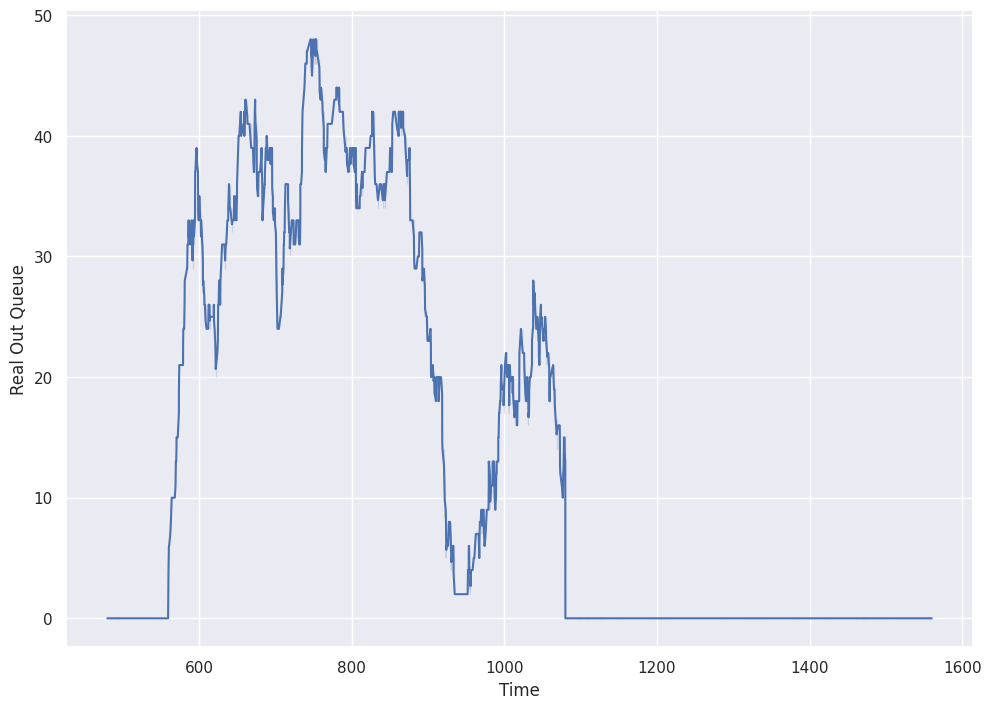

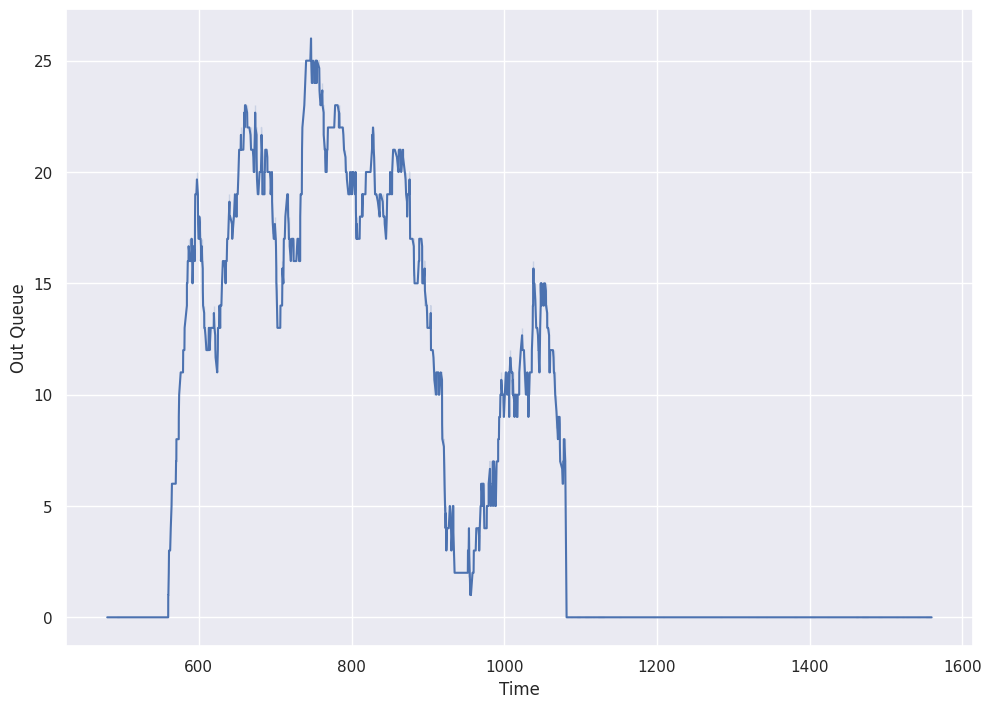

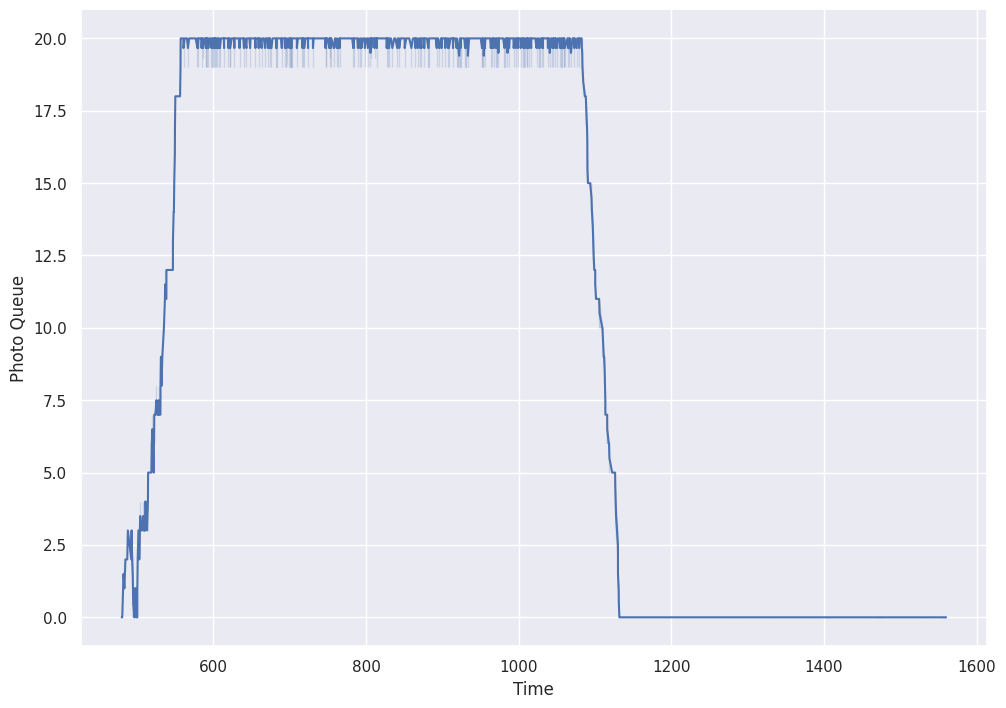

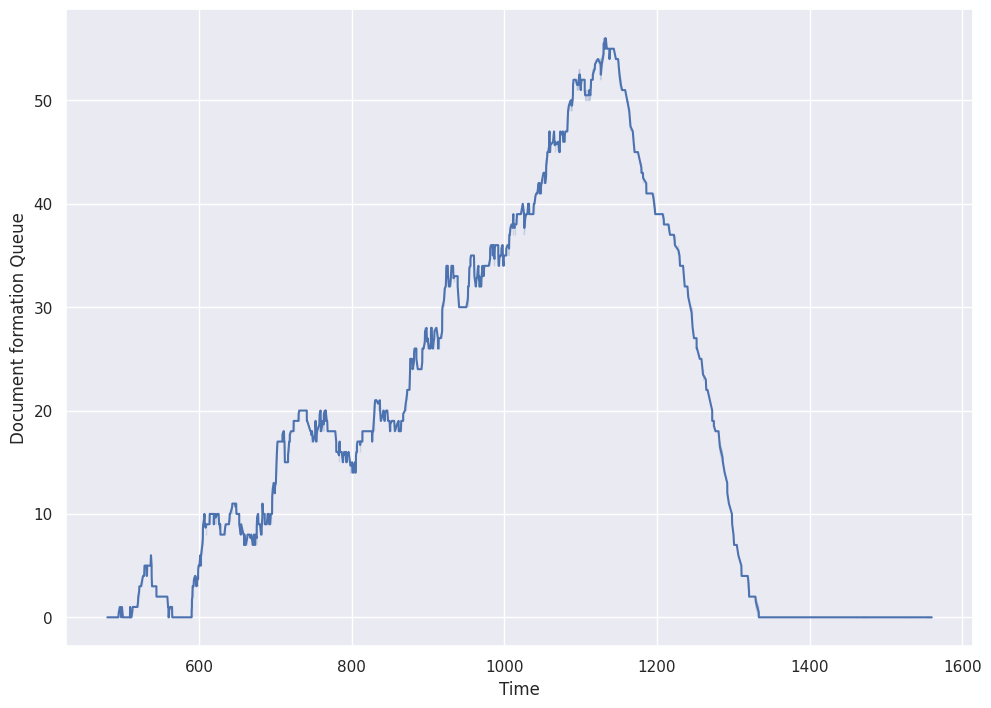

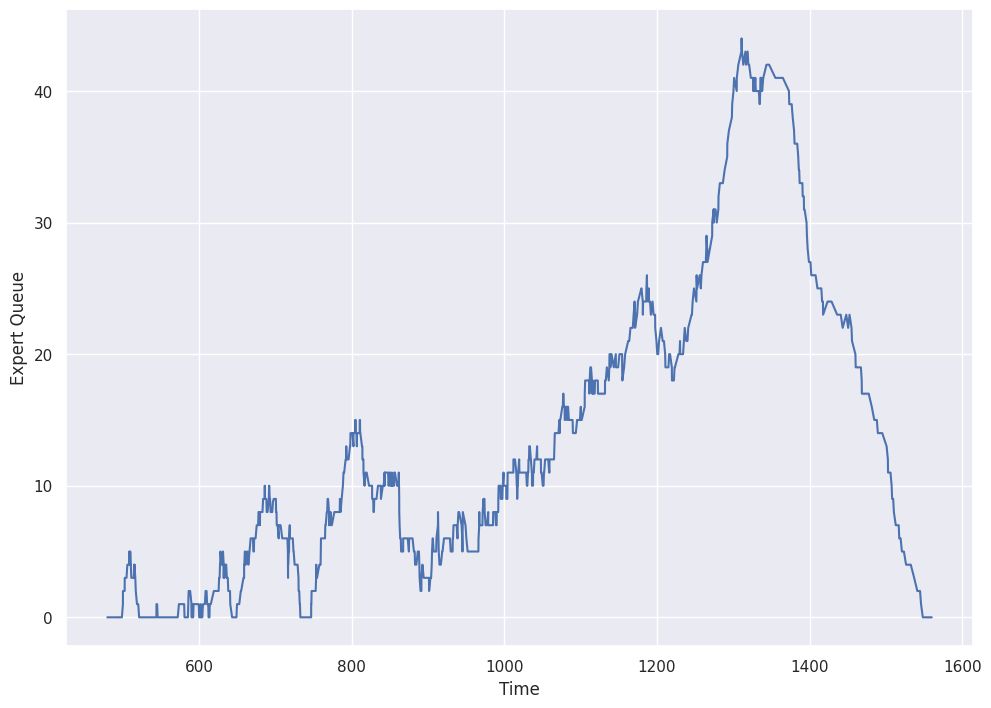

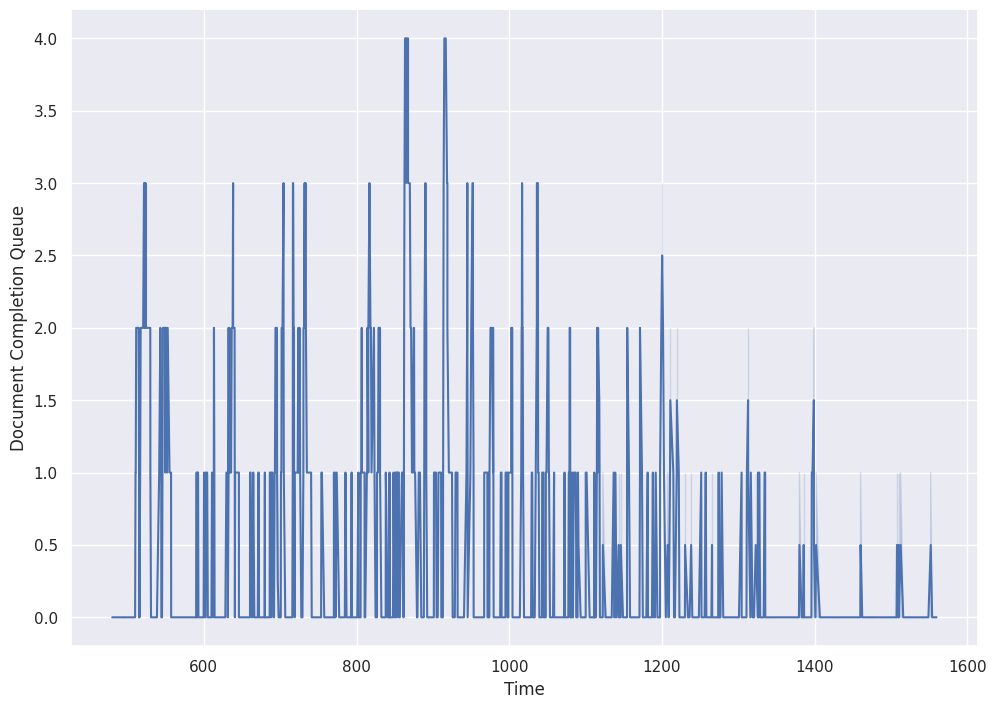

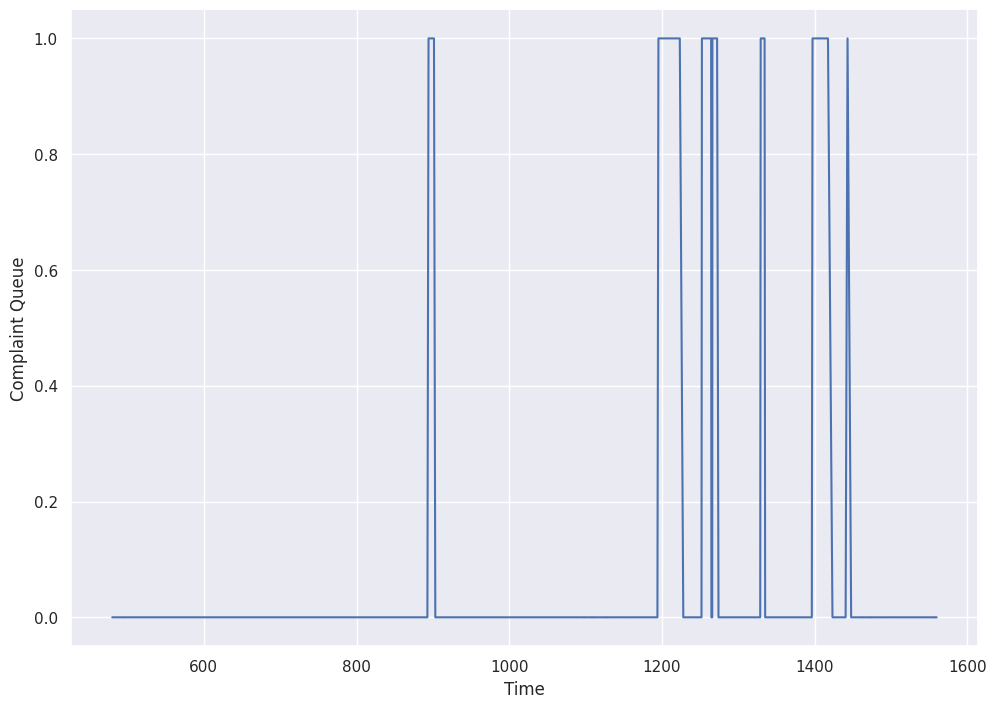

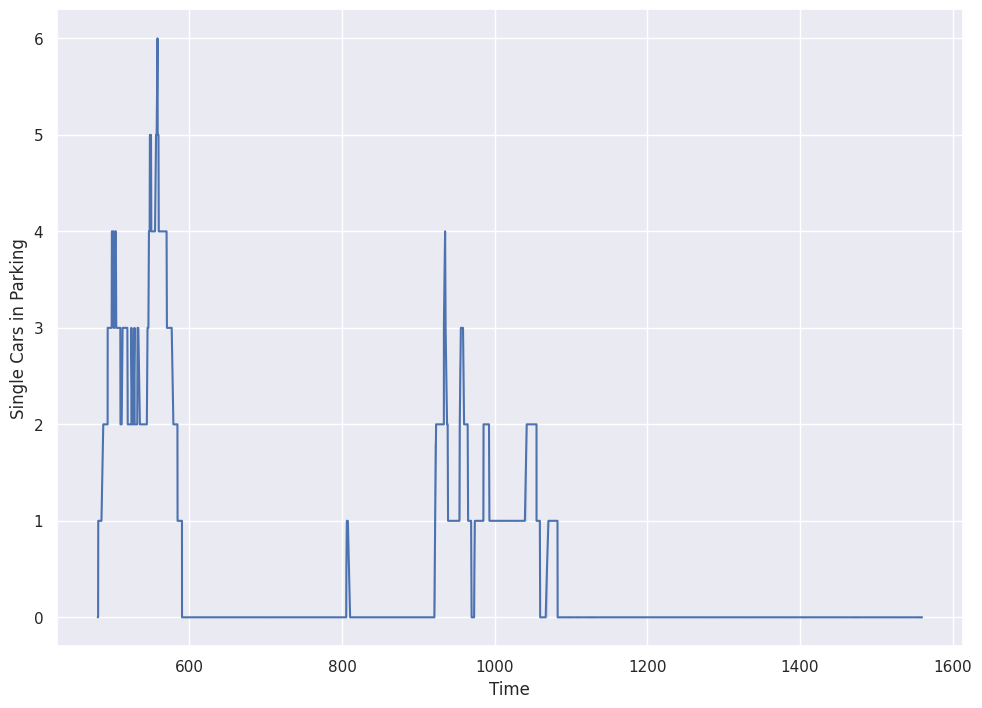

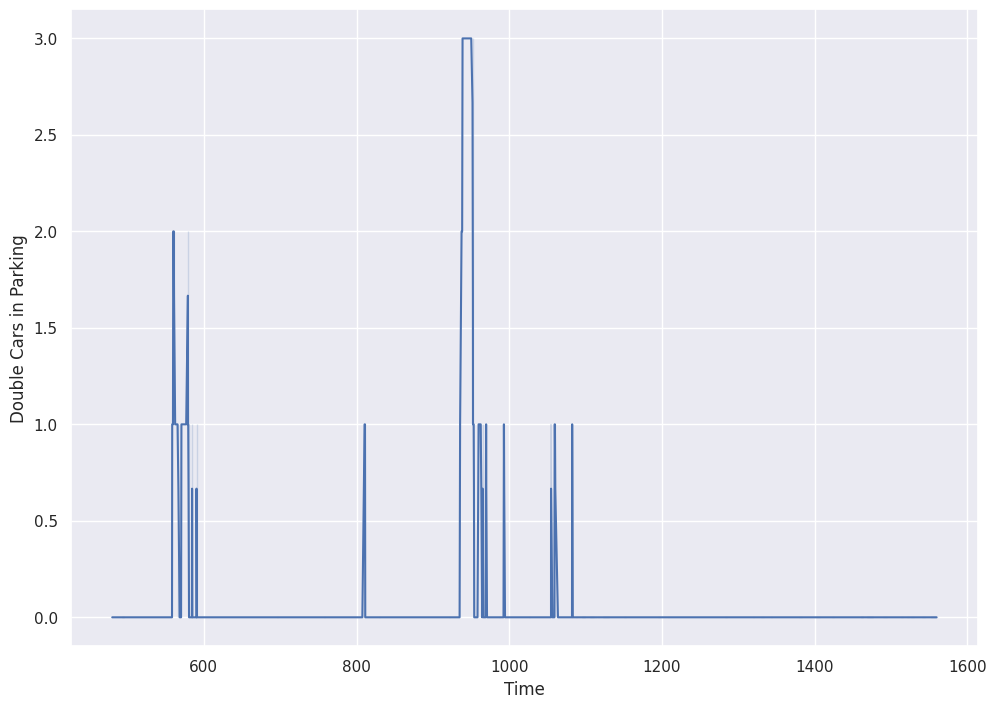

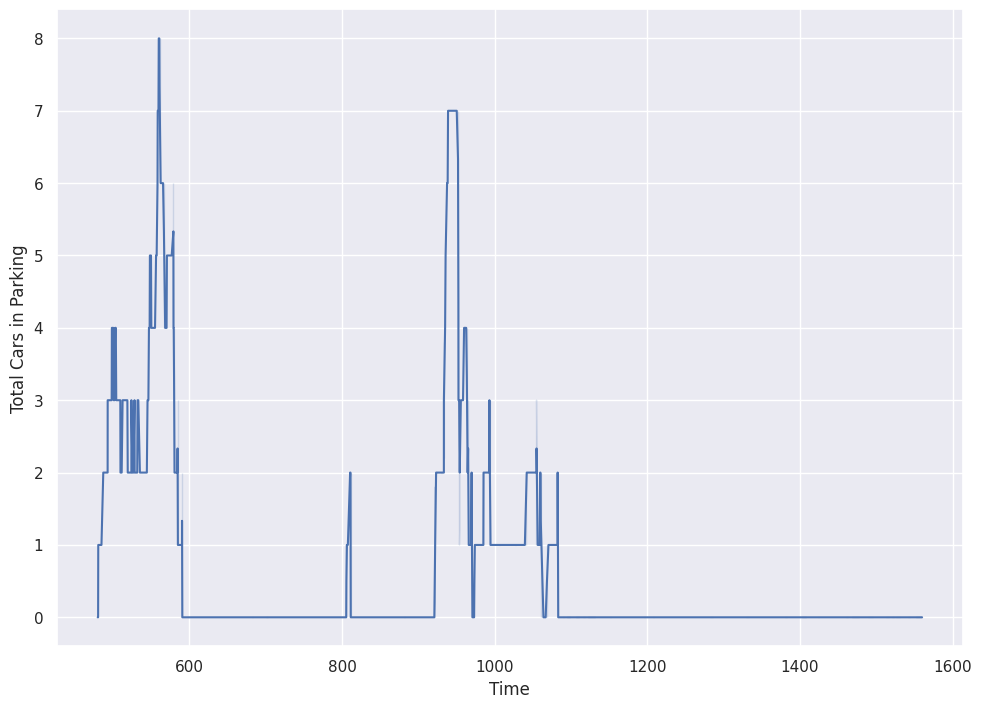

In [ ]:
model2 = insurance_center(param_type_proportion = 0.3  , param_Complaining = 0.1 ,
                         photo_cap = 20 , photo_server = 2 , document_server = 3 , expert_server = 2 , complaint_server = 1  )

model2.simulation(nice_print =  False , sim_days=1)
df2 = model2.data_frame()

ques = ['Out Queue' , 'Photo Queue' ,'Document formation Queue' , 'Expert Queue' , 'Document Completion Queue' , 'Complaint Queue' , 'Single Cars in Parking' , 'Double Cars in Parking' , "Total Cars in Parking"]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=model2.outque_data_frame(), x="time", y="outquelength")
plt.xlabel("Time")
plt.ylabel("Real Out Queue")
plt.show()
print()
for i in ques:
  sns.lineplot(data=df2, x="Event Time", y=i)
  plt.xlabel("Time")
  plt.show()
  print()

***Part three:***

In this section, the key performance indicators of the system are calculated.
Each function takes a queue name (or operator) and an alpha value as input.



In [ ]:
"""
The following functions calculate the point estimator and interval estimator for each KPI.
"""
def CI_Calcilator_waiting_time_in_que(q,alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      dff1 = model.data_frame()
      dff2 = dff1[dff1["Day"] == i ]
      dff3 = dff2[dff2["Event Type"] != "Arrival frome outside to inside" ]

      df2 = model.waiting_df()

      dff4 = pd.to_numeric(dff3["ID"], errors='coerce')
      max = dff4.max()
      min = dff4.min()

      df = df2[(df2['ID'] >= min) & (df2['ID'] <= max)]
      df.fillna(0)

      df["ans"] = df[q + " exit"] - df[q + " enter"]

      ave_list.append((df["ans"].sum())/(len(df["ans"])))

    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar = final_Y.mean()
  S = final_Y.std()
    # create 95% confidence interval
  tails = 2
    # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
    # Degrees of freedom
  dof = len(Y_bars)-1
    # Critical t-statistic, calculated using the percent-point function (aka the
    # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
    # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))
  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)


def CI_calculator_average_of_being_is_system(alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      ave_list.append(model.average_of_being_is_system(day=i))
    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar = final_Y.mean()
  S = final_Y.std()
    # create 95% confidence interval
  tails = 2
    # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
    # Degrees of freedom
  dof = len(Y_bars)-1
    # Critical t-statistic, calculated using the percent-point function (aka the
    # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
    # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))
  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)

def CI_calculator_prob_of_empty(queue , alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      ave_list.append(model.prob_of_empty(q=queue , day=i))
    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar =final_Y.mean()
  S = final_Y.std()
  # create 95% confidence interval
  tails = 2
  # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
  # Degrees of freedom
  dof = len(Y_bars)-1
  # Critical t-statistic, calculated using the percent-point function (aka the
  # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
  # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))
  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)

def CI_calculator_max_que(queue , alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      ave_list.append(model.max_que(q=queue , day=i))
    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar = final_Y.mean()
  S = final_Y.std()
  # create 95% confidence interval
  tails = 2
  # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
  # Degrees of freedom
  dof = len(Y_bars)-1
  # Critical t-statistic, calculated using the percent-point function (aka the
  # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
  # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))
  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)

def CI_calculator_average_que_length(queue , alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      ave_list.append(model.average_que_length(q=queue , day=i))
    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar = final_Y.mean()
  S = final_Y.std()
  # create 95% confidence interval
  tails = 2
  # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
  # Degrees of freedom
  dof = len(Y_bars)-1
  # Critical t-statistic, calculated using the percent-point function (aka the
  # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
  # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))
  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)


def CI_calculator_server_utilization(operator , alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      ave_list.append(model.server_utilization(server= operator , day=i))
    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar = final_Y.mean()
  S = final_Y.std()
  # create 95% confidence interval
  tails = 2
  # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
  # Degrees of freedom
  dof = len(Y_bars)-1
  # Critical t-statistic, calculated using the percent-point function (aka the
  # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
  # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))
  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)

def CI_calculator_coVSnotco(alpha):
  Y_bars=[]
  for j in range(0,5):
    ave_list=[]
    for i in range((j*30)+1,(j*30)+31):
      ave_list.append(model.coVSnotco(day=i))
    Y_bars.append((np.array(ave_list)).mean())

  final_Y= (np.array(Y_bars))
  Y_bar_bar = final_Y.mean()
  S = final_Y.std()

  # create 95% confidence interval
  tails = 2
  # Quantile (the cumulative probability)
  q = 1 - (alpha / tails)
  # Degrees of freedom
  dof = len(Y_bars)-1
  # Critical t-statistic, calculated using the percent-point function (aka the
  # quantile function) of the t-distribution
  t_star = stats.t.ppf(q, dof)
  # Confidence interval
  ci_upper = Y_bar_bar  + t_star * S / np.sqrt(len(Y_bars))
  ci_lower = Y_bar_bar - t_star * S / np.sqrt(len(Y_bars))

  print('Point estimate:',Y_bar_bar)
  print('We are 95% sure that the true mean lies between :',ci_lower,' ', ci_upper)

In [ ]:
CI_calculator_average_of_being_is_system(alpha=0.05)

Point estimate: 341.9420703701567
We are 95% sure that the true mean lies between : 214.0434895462385   469.84065119407495


In [ ]:
CI_calculator_prob_of_empty(queue='Document formation Queue' , alpha=0.05)

Point estimate: 0.8705727588077571
We are 95% sure that the true mean lies between : 0.8522914779646771   0.8888540396508371


In [ ]:
CI_calculator_prob_of_empty(queue='Total Cars in Parking' , alpha=0.05)

Point estimate: 0.5705818614946278
We are 95% sure that the true mean lies between : 0.5296366290871453   0.6115270939021102


In [ ]:
CI_calculator_max_que(queue='Photo Queue' , alpha=0.05)

Point estimate: 19.126666666666665
We are 95% sure that the true mean lies between : 18.682898431948125   19.570434901385205


In [ ]:
CI_calculator_max_que(queue='Out Queue' , alpha=0.05)

Point estimate: 108.69333333333334
We are 95% sure that the true mean lies between : 84.16774833715155   133.21891832951513


In [ ]:
CI_calculator_max_que(queue='Complaint Queue' , alpha=0.05)

Point estimate: 1.9600000000000002
We are 95% sure that the true mean lies between : 1.8887920161004972   2.031207983899503


In [ ]:
CI_calculator_max_que(queue='Expert Queue' , alpha=0.05)

Point estimate: 49.65333333333333
We are 95% sure that the true mean lies between : 47.02840878384088   52.27825788282578


In [ ]:
CI_calculator_average_que_length(queue='Photo Queue' , alpha=0.05)

Point estimate: 7.504560740227855
We are 95% sure that the true mean lies between : 6.894901694704596   8.114219785751114


In [ ]:
CI_calculator_average_que_length(queue='Out Queue' , alpha=0.05)

Point estimate: 36.22878830980697
We are 95% sure that the true mean lies between : 27.660355257262406   44.797221362351536


In [ ]:
CI_calculator_average_que_length(queue='Complaint Queue' , alpha=0.05)

Point estimate: 0.10678567238901653
We are 95% sure that the true mean lies between : 0.09567032874058874   0.11790101603744431


In [ ]:
CI_calculator_average_que_length(queue='Expert Queue' , alpha=0.05)

Point estimate: 38.453031979434655
We are 95% sure that the true mean lies between : 32.42901703980743   44.477046919061884


In [ ]:
CI_calculator_server_utilization(operator='Photo Server' , alpha=0.05)

Point estimate: 0.5819713799602252
We are 95% sure that the true mean lies between : 0.5740472695437593   0.5898954903766911


In [ ]:
CI_calculator_server_utilization(operator='Expert Server' , alpha=0.05)

Point estimate: 0.951095208788278
We are 95% sure that the true mean lies between : 0.9438573016169367   0.9583331159596193


In [ ]:
CI_calculator_server_utilization(operator='Document Server' , alpha=0.05)

Point estimate: 0.8478879002056573
We are 95% sure that the true mean lies between : 0.834359793280041   0.8614160071312736


In [ ]:
CI_calculator_server_utilization(operator='Complaint Server' , alpha=0.05)

Point estimate: 0.2809471326884966
We are 95% sure that the true mean lies between : 0.26457555810017414   0.297318707276819


In [ ]:
CI_calculator_coVSnotco(alpha=0.05)

[1.4237335944255085, 1.4113419360342714, 1.4599460183913648, 1.447791361999918, 1.4598952386306712] 0.019691537560629135
Point estimate: 1.4405416298963467
We are 95% sure that the true mean lies between : 1.4160913566380362   1.4649919031546572


In [ ]:
CI_Calcilator_waiting_time_in_que(q='Photo Queue',alpha=0.05)

Point estimate: 30.840211631590932
We are 95% sure that the true mean lies between : 26.56792839413145   35.112494869050416


In [ ]:
CI_Calcilator_waiting_time_in_que(q='Out Queue',alpha=0.05)

In [ ]:
CI_Calcilator_waiting_time_in_que(q='Complaint Queue',alpha=0.05)

In [ ]:
CI_Calcilator_waiting_time_in_que(q='Expert Queue',alpha=0.05)

***Part four:***

In this section, the sensitivity analysis of the system is discussed.
Different simulation results with different values have been stored in an Excel file, which is called in this section, and the changes in the results are shown.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/My Drive/sensetive_analysis.xlsx'
my_data = pd.read_excel(path)

In [ ]:
my_data

Service distribution parameter of photography department  \
0                                                  2          
1                                                  4          
2                                                  6          
3                                                  8          

   Average length of stay in the system  \
0                                602.80   
1                                387.23   
2                                340.67   
3                                306.74   

   The probability that the  document formation queue is empty  \
0                                             0.2220             
1                                             0.2340             
2                                             0.2541             
3                                             0.3470             

   Average queue length of Expert department  \
0                                      32.21   
1                                      24.40   
2                                      21.44   
3                                      14.20   

   The parameter of the percentage of single customers  \
0                                               0.15     
1                                               0.30     
2                                               0.45     
3                                               0.60     

   Average length of stay in the system.1  \
0                                  361.96   
1                                  343.00   
2                                  363.96   
3                                  364.07   

   The probability that the  document formation queue is empty.1  \
0                                              0.240               
1                                              0.274               
2                                              0.250               
3                                              0.260               

   Average queue length of Expert department.1  \
0                                        20.30   
1                                        22.11   
2                                        20.89   
3                                        21.01   

   The parameter of the number of servers in document part  \
0                                                  2         
1                                                  3         
2                                                  4         
3                                                  5         

   Average length of stay in the system.2  \
0                                  515.78   
1                                  350.55   
2                                  326.31   
3                                  341.95   

   The probability that the  document formation queue is empty.2  \
0                                             0.0450               
1                                             0.2500               
2                                             0.6733               
3                                             0.8700               

   Average queue length of Expert department.2  
0                                         1.55  
1                                        20.51  
2                                        36.53  
3                                        38.45

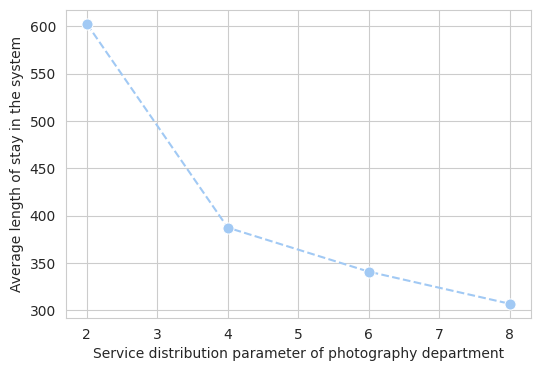

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(6, 4))
sns.lineplot(x=my_data['Service distribution parameter of photography department'], y=my_data['Average length of stay in the system'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()


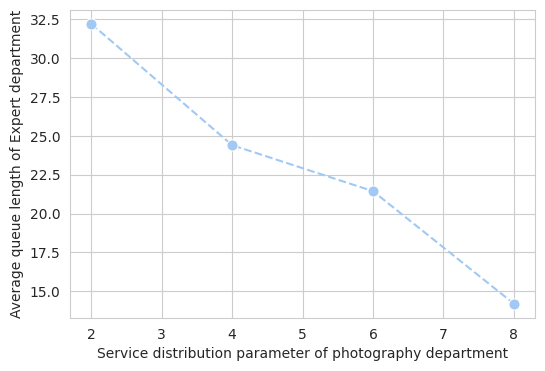

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(6, 4))
sns.lineplot(x=my_data['Service distribution parameter of photography department'], y=my_data['Average queue length of Expert department'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()

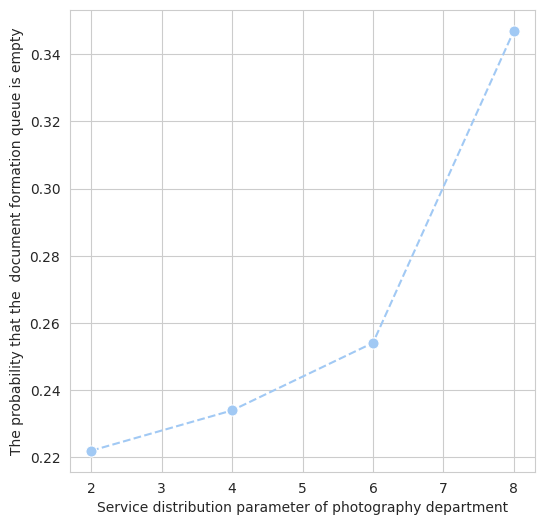

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color

sns.lineplot(x=my_data['Service distribution parameter of photography department'], y=my_data['The probability that the  document formation queue is empty'], color=colors[0], linestyle='--',marker='o', markersize=8)
plt.show()

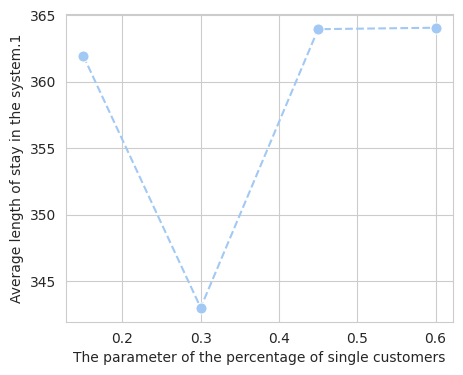

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(5, 4))
sns.lineplot(x=my_data['The parameter of the percentage of single customers'], y=my_data['Average length of stay in the system.1'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()


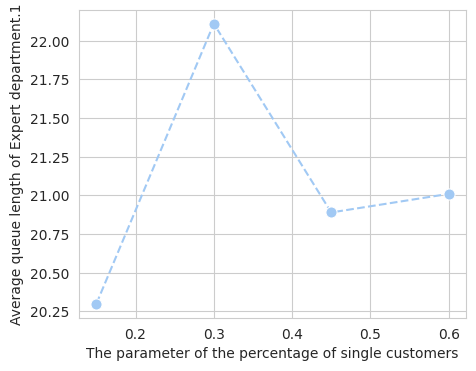

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(5, 4))
sns.lineplot(x=my_data['The parameter of the percentage of single customers'], y=my_data['Average queue length of Expert department.1'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()

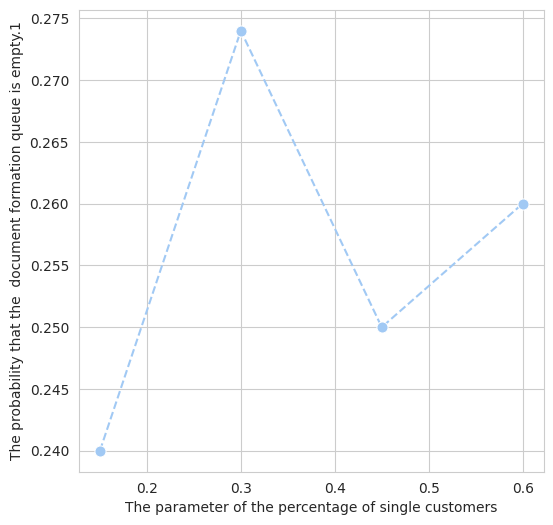

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(6, 6))
sns.lineplot(x=my_data['The parameter of the percentage of single customers'], y=my_data['The probability that the  document formation queue is empty.1'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()

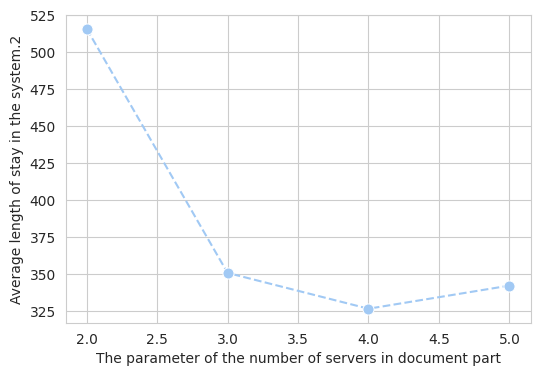

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(6, 4))
sns.lineplot(x=my_data['The parameter of the number of servers in document part'], y=my_data['Average length of stay in the system.2'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()

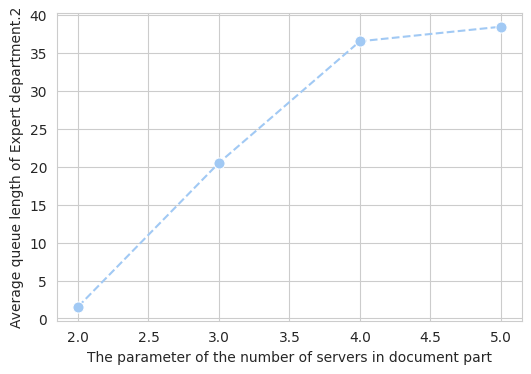

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(6, 4))
sns.lineplot(x=my_data['The parameter of the number of servers in document part'], y=my_data['Average queue length of Expert department.2'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()

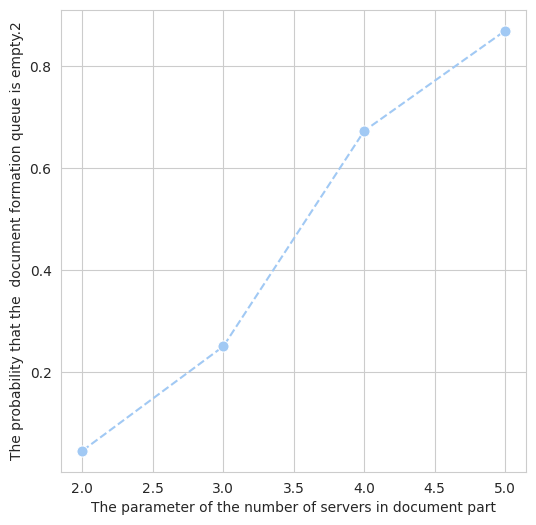

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
colors = sns.color_palette("pastel")

# Create the line plot with customized line style and color
plt.figure(figsize=(6, 6))
sns.lineplot(x=my_data['The parameter of the number of servers in document part'], y=my_data['The probability that the  document formation queue is empty.2'], color=colors[0], linestyle='--', marker='o', markersize=8)
plt.show()

***Part five:***

In this section, the class related to the insurance center has been changed in such a way that the changes related to the stability of the system are made.

For this, the possible variables will have the value 0.
Also the simulation end event has changed.


In [ ]:
class insurance_center_steady:
    """
    This class is an insurance center simulator.
    There are various functions in this class. Some are for advancing the simulation and some are for outputting and inputting data.
    """
    def __init__(self,param_type_proportion  , param_Complaining ,
                 photo_cap , photo_server , document_server , expert_server , complaint_server , sim_end_time , system_type ):
        """
        In this function, the initial values of the simulation parameters are defined.
        param_type_proportion: The probability that the car entering the system is single
        param_Complaining: The probability that the customer who enters the system intends to complain.
        photo_cap: The capacity of the photo queue
        photo_server: The number of operators who serve in the photography department.
        document_server: The number of operators who serve in the document department.
        expert_server: The number of operators who serve in the expert department.
        complaint_server: The number of operators who serve in the complaint department.
        """
        self.data = dict()
        self.state = dict()
        self.future_event_list = list()
        self.param_type_proportion = param_type_proportion #0.3
        self.param_Complaining = param_Complaining #0.1

        #indicates the clock in the simulation
        self.clock = 0

        self.sorted_fel = None
        self.current_event = None
        self.customer = dict()
        self.ques = dict()

        self.photo_cap = photo_cap #20
        self.photo_server = photo_server #2
        self.document_server = document_server #3
        self.expert_server = expert_server #2
        self.complaint_server = complaint_server #1

        #Customer ID
        self.id = 0

        self.sim_end_time = sim_end_time

        self.table = list()

        self.day = 0
        self.end_of_sim = False
        self.system_type = system_type
    """
    The following functions are used to generate random values with a given distribution and parameter.
    """
    def S_photo(self):
      if self.system_type == 1 :
        return exponential(1/6)
      elif self.system_type == 2 :
        return exponential(1/6)

    def S_formation(self):
      if self.system_type == 1 :
        return triangular(5,6,7)
      elif self.system_type == 2 :
        return triangular(6,8,10)

    def S_expert(self):
      if self.system_type == 1 :
        return exponential(1/9)
      elif self.system_type == 2 :
        return exponential(1/8)

    def S_completion(self):
      if self.system_type == 1 :
        return triangular(6,8,9)
      elif self.system_type == 2 :
        return triangular(3,3.5,4)

    def S_complaint(self):
      if self.system_type == 1 :
        return exponential(1/15)
      elif self.system_type == 2 :
        return exponential(1/15)

    def S_single(self):
      return exponential(1/30)

    def S_enter(self):
      if self.system_type == 1 :
        return exponential(1/5)
      elif self.system_type == 2 :
        return exponential(1/3.2)

    def type_of_day_maker(self):
      """
      This function randomly determines the type of day.(rainy or normal)
      """
      r = rnd.random()
      if r > 0.31:
        return("normal")
      if r <= 0.31:
        return("rainy")


    def data_def(self):
        """
        This function defines the lists and dictionaries that are needed for data storage.
        """
        #To store the entry and exit time of each customer from each queue
        #{id:[enter , exit]}

        self.waitting = dict()
        self.waitting['Out Queue'] = dict()
        self.waitting['Photo Queue'] = dict()
        self.waitting['Expert Queue'] = dict()
        self.waitting['Document Completion Queue'] = dict()
        self.waitting['Complaint Queue'] = dict()
        self.waitting['Document formation Queue'] = dict()
        self.waitting['Single Cars in Parking'] = dict()
        self.waitting['Double Cars in Parking'] = dict()
        self.waitting['day'] = 0




    def starting_state(self):
        """
        This function determines the initial conditions for starting the simulation.
        """

        # State variables of Queues
        self.state['Out Queue'] = 0
        self.state['Photo Queue'] = 0
        self.state['Document formation Queue'] = 0
        self.state['Expert Queue'] = 0
        self.state['Document Completion Queue'] = 0
        self.state['Complaint Queue'] = 0
        # State variables of servers
        self.state['Photo Server'] = 0
        self.state['Document Server'] = 0
        self.state['Expert Server'] = 0
        self.state['Complaint Server'] = 0
        # State variables of Parking
        self.state['Single Cars in Parking'] = 0
        self.state['Double Cars in Parking'] = 0


        #The following lists store the information of the customers who are in each queue at that moment.
        self.ques['Out Queue'] = [{"id" : -1 , "type" : None}]
        self.ques['Photo Queue'] = list()
        self.ques['Document formation Queue'] = list()
        self.ques['Expert Queue'] = list()
        self.ques['Document Completion Queue'] = list()
        self.ques['Complaint Queue'] = list()
        self.ques['Single Cars in Parking'] = [{"id" : 0 , "type" : None}]
        self.ques['Double Cars in Parking'] = list()

        #The actual number of people in outside queue

        self.realoutque = {"time" : [] , "outquelength" : []}







        # FEL initialization, and Starting events that initialize the simulation
        #self.future_event_list.append({'Event Type': 'start', 'Event Time': 0, 'customer': ''})

        #{id  : id , type : single or double ,complaint:  0 or 1 ,work:  0 or 1}
        self.future_event_list = list()
        c = self.customer_maker()
        self.future_event_list.append({'Event Type': 'Arrival insurance', 'Event Time': 480, 'customer': c })
        self.future_event_list.append({'Event Type': 'End of simulation', 'Event Time': self.sim_end_time , 'customer': None })


    def fel_maker(self, event_type: str, customer: None , type_of_day = None ):
      """
      This function is supposed to set the next event into future event list
      future_event_list: list that contains all future events
      param event_type: types of each event that can occur in this simulation
      clock: Simulation clock
      param customer: A dict that filled with each user's attributes
      param type_of_day: The day type is stored in this variable

      """

      if event_type == 'Arrival insurance':
        event_time = self.clock + self.S_enter()

      elif event_type == 'Arrival single vehicle':
        event_time = self.clock + self.S_single()

      elif event_type == 'Arrival frome outside to inside':
        event_time = self.clock

      elif event_type == 'End of photography':
        event_time = self.clock + self.S_photo()

      elif event_type == 'End of document formation':
        event_time = self.clock + self.S_formation()

      elif event_type == 'End of document completion':
        event_time = self.clock + self.S_completion()

      elif event_type == 'End of expert checking':
        event_time = self.clock + self.S_expert()

      elif event_type == 'End of complaint':
        event_time = self.clock + self.S_complaint()

      elif event_type == 'End of simulation':
        event_time = self.clock


      new_event = {'Event Type': event_type, 'Event Time': event_time, 'customer': customer}
      self.future_event_list.append(new_event)




    def customer_maker(self):
      """
      This function randomly generates a customer with its features.
      {id  : id , type : S(sinle) or D(double) ,  complaint: 1(yes) or 0(no),  work:  1(yes) or 0(no)}

      """
      rnd1 = rnd.random()
      rnd2 = rnd.random()
      self.id +=1 #Create a new ID
      if  rnd1 > self.param_type_proportion:
        if rnd2 > self.param_Complaining:
          return({"id"  : self.id , "type" : "D" ,"complaint":  0 ,"work":  0})

        if rnd2 <= self.param_Complaining:
          return({"id"  : self.id  , "type" : "D" ,"complaint":  1 ,"work":  0})

      else:
        if rnd2 > self.param_Complaining:
          return({"id"  : self.id  , "type" : "S" ,"complaint":  0 ,"work":  0})

        if rnd2 <= self.param_Complaining:
          return({"id"  : self.id  , "type" : "S" ,"complaint":  1 ,"work":  0})



    def  Arrival_insurance(self):


      if self.customer["type"] == "D":
        if self.state["Out Queue"] > 0:
          self.state["Out Queue"] += 1
          self.ques['Out Queue'].append(self.customer)
          self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

          id = str(self.customer["id"])
          self.waitting['Out Queue'][id] = [None , None ]
          self.waitting['Out Queue'][id][0] = self.clock


        elif self.state["Out Queue"] == 0:
          if self.state["Photo Queue"] == 0:
            if self.state["Photo Server"] == self.photo_server:
              self.state["Photo Queue"] += 1
              self.ques['Photo Queue'].append(self.customer)
              self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )


              id = str(self.customer["id"])
              self.waitting['Photo Queue'][id] = [None , None ]
              self.waitting['Photo Queue'][id][0] = self.clock





            elif self.state["Photo Server"] < self.photo_server:
              self.state["Photo Server"] += 1
              self.fel_maker('End of photography' , self.customer , None )
              self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )



          elif self.state["Photo Queue"] < self.photo_cap:
            self.state["Photo Queue"] +=1
            self.ques['Photo Queue'].append(self.customer)
            self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

            id = str(self.customer["id"])
            self.waitting['Photo Queue'][id] = [None , None ]
            self.waitting['Photo Queue'][id][0] = self.clock


          elif self.state["Photo Queue"] == self.photo_cap:
            self.state["Out Queue"] += 1
            self.ques['Out Queue'].append(self.customer)
            self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

            id = str(self.customer["id"])
            self.waitting['Out Queue'][id] = [None , None ]
            self.waitting['Out Queue'][id][0] = self.clock





      elif self.customer["type"] == "S":
        if self.state["Out Queue"] == 0:
          self.state['Single Cars in Parking'] += 1
          self.ques['Single Cars in Parking'].append(self.customer)
          self.fel_maker('Arrival single vehicle' , self.customer , None )

          self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

          id = str(self.customer["id"])
          self.waitting['Single Cars in Parking'][id] = [None , None ]
          self.waitting['Single Cars in Parking'][id][0] = self.clock



        elif self.state["Out Queue"] > 0:
          self.state['Out Queue'] += 1
          self.ques['Out Queue'].append(self.customer)
          self.fel_maker('Arrival single vehicle' , self.customer , None )
          self.fel_maker('Arrival insurance' , self.customer_maker() , self.type_of_day )

          id = str(self.customer["id"])
          self.waitting['Out Queue'][id] = [None , None ]
          self.waitting['Out Queue'][id][0] = self.clock






    def Arrival_single_vehicle(self):

      if search_id(self.customer["id"] , self.ques['Single Cars in Parking']) == False:
        if search_id(self.customer["id"] , self.ques['Out Queue']) == False:
          pass


        else:
          i = search_id(self.customer["id"] , self.ques['Out Queue'])
          self.ques['Out Queue'][i]["type"] = "D"

      else:
        self.state['Single Cars in Parking'] -= 1
        self.state['Double Cars in Parking'] += 1
        i = search_id(self.customer["id"] , self.ques['Single Cars in Parking'])


        id = str(self.customer["id"])
        self.waitting['Single Cars in Parking'][id][1] = self.clock

        self.waitting['Double Cars in Parking'][id] = [None , None ]
        self.waitting['Double Cars in Parking'][id][0] = self.clock

        self.ques['Double Cars in Parking'].append(self.ques['Single Cars in Parking'][i])
        del self.ques['Single Cars in Parking'][i]
        self.ques['Double Cars in Parking'][-1]["type"] = "D"

        if self.state['Photo Server'] == self.photo_server:
          if self.state['Photo Queue'] == self.photo_cap:
            pass

          elif self.state['Photo Queue'] < self.photo_cap:
            self.state['Photo Queue'] += 1
            self.state['Double Cars in Parking'] -= 1

            id = str(self.ques['Double Cars in Parking'][0]["id"])
            self.waitting['Double Cars in Parking'][id][1] = self.clock

            self.waitting['Photo Queue'][id] = [None , None ]
            self.waitting['Photo Queue'][id][0] = self.clock

            self.ques['Photo Queue'].append(self.ques['Double Cars in Parking'][0])
            del self.ques['Double Cars in Parking'][0]

        elif self.state['Photo Server'] < self.photo_server:
          self.state['Double Cars in Parking'] -= 1
          self.state['Photo Server'] += 1

          id = str(self.ques['Double Cars in Parking'][0]["id"])
          self.waitting['Double Cars in Parking'][id][1] = self.clock

          self.fel_maker('End of photography' , self.ques['Double Cars in Parking'][0] , None )
          del self.ques['Double Cars in Parking'][0]


    def Arrival_frome_outside_to_inside(self):
      if self.state['Photo Queue'] == self.photo_cap:
        pass

      elif self.state['Photo Queue'] < self.photo_cap:
        if self.state['Double Cars in Parking'] ==0:
          if  self.state["Out Queue"] == 0:
            pass

          elif self.state["Out Queue"] > 0:
            if self.ques['Out Queue'][1]['type']=='S':
              self.state["Out Queue"]-= 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Out Queue'][id][1] = self.clock

              self.state['Single Cars in Parking'] += 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Single Cars in Parking'][id] = [None , None ]
              self.waitting['Single Cars in Parking'][id][0] = self.clock

              self.ques['Single Cars in Parking'].append(self.ques['Out Queue'][1])
              del self.ques['Out Queue'][1]
              self.fel_maker('Arrival frome outside to inside' , None , None )

            elif self.ques['Out Queue'][1]['type']=='D':
              self.state['Photo Queue']+= 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Photo Queue'][id] = [None , None ]
              self.waitting['Photo Queue'][id][0] = self.clock


              self.state["Out Queue"]-= 1

              id = str(self.ques['Out Queue'][1]["id"])
              self.waitting['Out Queue'][id][1] = self.clock

              self.ques['Photo Queue'].append(self.ques['Out Queue'][1])
              del self.ques['Out Queue'][1]

              self.fel_maker('Arrival frome outside to inside' , None , None )

        elif self.state['Double Cars in Parking'] > 0:
          self.state['Double Cars in Parking'] -= 1

          id = str(self.ques['Double Cars in Parking'][0]["id"])
          self.waitting['Double Cars in Parking'][id][1] = self.clock

          self.ques['Photo Queue'].append(self.ques['Double Cars in Parking'][0])

          self.state['Photo Queue']+= 1

          id = str(self.ques['Double Cars in Parking'][0]["id"])
          self.waitting['Photo Queue'][id] = [None , None ]
          self.waitting['Photo Queue'][id][0] = self.clock

          del self.ques['Double Cars in Parking'][0]

          self.fel_maker('Arrival frome outside to inside' , None , None )



    def End_of_photography(self):
      if self.state['Photo Queue'] == 0:
        self.state['Photo Server'] -= 1

      elif self.state['Photo Queue'] > 0:
        self.state['Photo Queue'] -= 1

        id = str(self.ques['Photo Queue'][0]["id"])
        self.waitting['Photo Queue'][id][1] = self.clock

        self.fel_maker('End of photography' , self.ques['Photo Queue'][0] , None )
        del self.ques['Photo Queue'][0]
        self.fel_maker('Arrival frome outside to inside' , None , None )

      if self.state['Document formation Queue'] == 0:
        if self.state['Document Server'] == self.document_server:
          self.state['Document formation Queue'] += 1

          self.ques['Document formation Queue'].append(self.customer)

          id = str(self.customer["id"])
          self.waitting['Document formation Queue'][id] = [None , None ]
          self.waitting['Document formation Queue'][id][0] = self.clock

        elif self.state['Document Server'] < self.document_server:
          self.state['Document Server'] += 1
          self.fel_maker('End of document formation' , self.customer , None )

      elif self.state['Document formation Queue'] > 0:
        self.state['Document formation Queue'] += 1

        id = str(self.customer["id"])
        self.waitting['Document formation Queue'][id] = [None , None ]
        self.waitting['Document formation Queue'][id][0] = self.clock

        self.ques['Document formation Queue'].append(self.customer)

    def End_of_document_formation(self):
      if self.state['Document Completion Queue'] == 0:
        if self.state['Document formation Queue'] == 0:
          self.state['Document Server'] -= 1

        if self.state['Document formation Queue'] > 0:
          self.state['Document formation Queue'] -= 1

          id = str(self.ques['Document formation Queue'][0]["id"])
          self.waitting['Document formation Queue'][id][1] = self.clock

          self.fel_maker('End of document formation' , self.ques['Document formation Queue'][0] , None )
          del self.ques['Document formation Queue'][0]

      elif self.state['Document Completion Queue'] > 0:
        self.state['Document Completion Queue'] -=1
        self.fel_maker('End of document completion' , self.ques['Document Completion Queue'][0] , None )

        id = str(self.ques['Document Completion Queue'][0]["id"])
        self.waitting['Document Completion Queue'][id][1] = self.clock

        del self.ques['Document Completion Queue'][0]


      if self.state['Expert Queue'] == 0:
        if self.state['Expert Server'] == self.expert_server:
          self.state['Expert Queue'] += 1

          id = str(self.customer["id"])
          self.waitting['Expert Queue'][id] = [None , None ]
          self.waitting['Expert Queue'][id][0] = self.clock

          self.ques['Expert Queue'].append(self.customer)

        elif self.state['Expert Server'] < self.expert_server:
          self.state['Expert Server'] += 1
          self.fel_maker('End of expert checking' , self.customer , None )

      elif self.state['Expert Queue'] > 0:
        self.state['Expert Queue'] +=1

        id = str(self.customer["id"])
        self.waitting['Expert Queue'][id] = [None , None ]
        self.waitting['Expert Queue'][id][0] = self.clock

        self.ques['Expert Queue'].append(self.customer)


    def End_of_document_completion(self):
      if self.state['Document Completion Queue'] == 0:
        if self.state['Document formation Queue'] == 0:
          self.state['Document Server'] -= 1

        if self.state['Document formation Queue'] > 0:

          self.state['Document formation Queue'] -= 1

          id = str(self.ques['Document formation Queue'][0]["id"])
          self.waitting['Document formation Queue'][id][1] = self.clock

          self.fel_maker('End of document formation' , self.ques['Document formation Queue'][0] , None )
          del self.ques['Document formation Queue'][0]


      elif self.state['Document Completion Queue'] > 0:
        self.state['Document Completion Queue'] -=1

        id = str(self.ques['Document Completion Queue'][0]["id"])
        self.waitting['Document Completion Queue'][id][1] = self.clock

        self.fel_maker('End of document completion' , self.ques['Document Completion Queue'][0] , None )
        del self.ques['Document Completion Queue'][0]


    def End_of_expert_checking(self):
      if self.state['Expert Queue'] == 0:
        self.state['Expert Server'] -= 1

      elif self.state['Expert Queue'] > 0:
        self.state['Expert Queue'] -= 1

        id = str(self.ques['Expert Queue'][0]["id"])
        self.waitting['Expert Queue'][id][1] = self.clock

        self.fel_maker('End of expert checking' , self.ques['Expert Queue'][0] , None )
        del self.ques['Expert Queue'][0]

      if self.customer["complaint"] == 0:
        if self.state['Document Completion Queue'] == 0:
          if self.state['Document Server'] == self.document_server:
            self.state['Document Completion Queue'] += 1

            id = str(self.customer["id"])
            self.waitting['Document Completion Queue'][id] = [None , None ]
            self.waitting['Document Completion Queue'][id][0] = self.clock

            self.ques['Document Completion Queue'].append(self.customer)

          elif self.state['Document Server'] < self.document_server:
            self.state['Document Server'] += 1
            self.fel_maker('End of document completion' , self.customer , None )

        elif self.state['Document Completion Queue'] > 0:
          self.state['Document Completion Queue'] += 1

          id = str(self.customer["id"])
          self.waitting['Document Completion Queue'][id] = [None , None ]
          self.waitting['Document Completion Queue'][id][0] = self.clock

          self.ques['Document Completion Queue'].append(self.customer)

      elif self.customer["complaint"] == 1:
        if self.customer["work"] == 1 :

          if self.state['Document Completion Queue'] == 0:
            if self.state['Document Server'] == self.document_server:
              self.state['Document Completion Queue'] += 1

              id = str(self.customer["id"])
              self.waitting['Document Completion Queue'][id] = [None , None ]
              self.waitting['Document Completion Queue'][id][0] = self.clock

              self.ques['Document Completion Queue'].append(self.customer)

            elif self.state['Document Server'] < self.document_server:
              self.state['Document Server'] += 1
              self.fel_maker('End of document completion' , self.customer , None )

          elif self.state['Document Completion Queue'] > 0:
            self.state['Document Completion Queue'] += 1

            id = str(self.customer["id"])
            self.waitting['Document Completion Queue'][id] = [None , None ]
            self.waitting['Document Completion Queue'][id][0] = self.clock

            self.ques['Document Completion Queue'].append(self.customer)


        elif self.customer["work"] == 0 :
          c = self.customer
          c["work"] = 1

          if self.state['Complaint Queue'] == 0:
            if self.state['Complaint Server'] == self.complaint_server:
              self.state['Complaint Queue'] += 1

              id = str(self.customer["id"])
              self.waitting['Complaint Queue'][id] = [None , None ]
              self.waitting['Complaint Queue'][id][0] = self.clock

              self.ques['Complaint Queue'].append(c)

            elif self.state['Complaint Server'] < self.complaint_server:
              self.state['Complaint Server'] += 1
              self.fel_maker('End of complaint' , c , None )

          elif self.state['Complaint Queue'] > 0:
            self.state['Complaint Queue'] += 1

            id = str(self.customer["id"])
            self.waitting['Complaint Queue'][id] = [None , None ]
            self.waitting['Complaint Queue'][id][0] = self.clock

            self.ques['Complaint Queue'].append(c)



    def End_of_complaint(self):
      if self.state['Complaint Queue'] == 0 :
        self.state['Complaint Server'] -= 1

      elif self.state['Complaint Queue'] > 0 :
        self.state['Complaint Queue'] -= 1

        id = str(self.ques['Complaint Queue'][0]["id"])
        self.waitting['Complaint Queue'][id][1] = self.clock

        self.fel_maker('End of complaint' , self.ques['Complaint Queue'][0] , None )
        del self.ques['Complaint Queue'][0]


      if self.state['Expert Queue'] == 0 :
        if self.state['Expert Server'] == self.expert_server:
          self.state['Expert Queue'] += 1

          id = str(self.customer["id"])
          self.waitting['Expert Queue'][id] = [None , None ]
          self.waitting['Expert Queue'][id][0] = self.clock

          self.ques['Expert Queue'].append(self.customer)

        elif self.state['Expert Server'] < self.expert_server:
          self.state['Expert Server'] += 1
          self.fel_maker('End of expert checking' , self.customer , None )


      elif self.state['Expert Queue'] > 0:
        self.state['Expert Queue'] += 1

        id = str(self.customer["id"])
        self.waitting['Expert Queue'][id] = [None , None ]
        self.waitting['Expert Queue'][id][0] = self.clock


        self.ques['Expert Queue'].append(self.customer)

    def End_of_simulation(self):
      """
      This function determines whether the simulation ends or not.
      """

      self.end_of_sim = True



    def print_header(self):
      """
      This function is created to print the simulation outputs. In this function, the name of each column is printed.
      """
      print('Event Type'.ljust(40) + '\t' + 'Time'.ljust(15) + '\t'  + "Day".ljust(15) + '\t' + "type of day".ljust(15) + '\t' + "ID".ljust(15) + '\t'
                       + "type".ljust(15) + '\t' + "complaint".ljust(15)+ '\t'
                       +"work".ljust(15) , end = " ")
      for i in list(self.state.keys()):
        print('\t' + i.ljust(15)  , end = " ")
      print()
      print('-' * 290)

    def nice_print(self):
      """
      This function is created to print the simulation outputs.
      In this function, the state of each of the state variables at that moment is printed
      """
      if self.customer != None:
        print(str(self.current_event['Event Type']).ljust(40) + '\t' + str(round(self.current_event['Event Time'], 3)).ljust(15)  + '\t'+ str(self.day).ljust(15) + '\t' + self.type_of_day.ljust(15)
              + '\t'  + str(self.customer["id"]).ljust(15) + '\t' + self.customer["type"].ljust(15)  + '\t' + str(self.customer["complaint"]).ljust(15)+ '\t'
              + str(self.customer["work"]).ljust(15), end = " ")
      else:
        print(str(self.current_event['Event Type']).ljust(40) + '\t' + str(round(self.current_event['Event Time'], 3)).ljust(15) +'\t'+ str(self.day).ljust(15) + '\t' + self.type_of_day.ljust(15) + '\t'
              + "None".ljust(15) + '\t'+"None".ljust(15) + '\t'+"None".ljust(15) + '\t'+"None".ljust(15) , end = " ")

      for i in list(self.state.keys()):
        print(str(self.state[i]).ljust(10)  , end = " ")

      print()


    def table_header(self):
      """
      This function creates the column names of the system's output data frame.
      """
      l = []
      l.append("Event Type")
      l.append("Event Time")
      l.append("Day")
      l.append("type of day")
      l.append("ID")
      l.append("type")
      l.append("complaint")
      l.append("work")
      for i in self.state.keys():
        l.append(i)
      return l

    def row_maker(self):
      """
      This function is created to save the simulation outputs.
      In this function, the state of each of the state variables at that moment is saved.
      """
      l = []
      l.append(self.current_event['Event Type'])
      l.append(round(self.current_event['Event Time'], 3))
      l.append(self.day)
      l.append(self.type_of_day)
      if self.customer != None:
        l.append(self.customer["id"])
        l.append(self.customer["type"])
        l.append(self.customer["complaint"])
        l.append(self.customer["work"])

      else:
        l.append("None")
        l.append("None")
        l.append("None")
        l.append("None")

      for i in self.state.keys():
        l.append(self.state[i])
      return l


    def simulation(self  , nice_print = True  , sim_days =10 ):
      """
      This function is meant to do the simulation by help of introduced events.
      data and state dictionary will be saved after one replication is done.
      param nice_print: if true it will print all state variables. if false it will not.
      param sim_days: Determines how many days the simulation will continue.
      """
      self.table = list()
      if nice_print == True:
          self.print_header()
      self.data_def()
      self.id = 0


      self.type_of_day = self.type_of_day_maker()
      self.starting_state()
      self.clock = 480

      while self.end_of_sim == False :
        self.day = int((self.clock//1440) + 1)

        self.sorted_fel = sorted(self.future_event_list, key=lambda x: x['Event Time'])

        self.current_event = self.sorted_fel[0]  # find imminent event
        self.clock = self.current_event['Event Time']  # advance time to current

        self.customer = self.current_event['customer']  # find the customer of that event

        if nice_print == True:
          self.nice_print()

        self.table.append(self.row_maker())

        if self.current_event['Event Type'] == 'Arrival insurance':

            self.Arrival_insurance()

        elif self.current_event['Event Type'] == 'Arrival single vehicle':
            self.Arrival_single_vehicle()

        elif self.current_event['Event Type'] == 'Arrival frome outside to inside':
            self.Arrival_frome_outside_to_inside()

        elif self.current_event['Event Type'] == 'End of photography':
            self.End_of_photography()

        elif self.current_event['Event Type'] == 'End of document formation':
            self.End_of_document_formation()

        elif self.current_event['Event Type'] == 'End of document completion':
            self.End_of_document_completion()

        elif self.current_event['Event Type'] == 'End of expert checking':
            self.End_of_expert_checking()

        elif self.current_event['Event Type'] == 'End of complaint':
            self.End_of_complaint()

        elif self.current_event['Event Type'] == 'End of simulation':
            self.End_of_simulation()


        self.future_event_list.remove(self.current_event)
        self.outquelength()


    def outquelength(self):
      """
      This function determines the actual value of the number of people in the queue outside.
      This calculation is based on the number of double and single cars.
      """
      self.realoutque["time"].append(self.clock)
      sum = 0
      for i in self.ques['Out Queue']:
        if i["type"] == "S":
          sum += 1
        elif i["type"] == "D":
          sum += 2
        else:
          sum += 0

      self.realoutque["outquelength"].append(sum)

    def outque_data_frame(self):
      """
      This function converts the actual value of the out queue into a dataframe
      """
      df = pd.DataFrame(self.realoutque)

      return df




    def data_frame(self):
      """
      This function converts all state data saved during the simulation into a dataframe.
      """
      df = pd.DataFrame(self.table, columns = self.table_header())
      df["Total Cars in Parking"] = df["Single Cars in Parking"] + df["Double Cars in Parking"]*2
      df["Real Out Que"] = self.outque_data_frame()["outquelength"]
      return df


    def average_of_being_is_system(self , day):
      """
      This function calculates the average duration of the customer's presence in the system.
      param day: Determines for which day of the simulation, the calculations will be performed.
      """
      l = []
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]

      users = list(df['ID'].unique())
      try:
        users.remove("None")
      except:
        pass
      for i in users:
        x = df[df["ID"] == i ]
        enter = x[x["Event Type"] == "Arrival insurance" ]["Event Time"]
        try:
          exit = x[x["Event Type"] == "End of document completion" ]["Event Time"]
          time = float(exit) -float(enter)
          l.append(time)
        except:
          pass

      return sum(l) / len(l)


    def max_que(self , q , day):
      """
      This function calculates the maximum length of the queue.
      param day: Determines for which day of the simulation, the calculations will be performed.
      param q: Determines for which queue of the system the calculations will be performed
      """

      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      return df[q].max()

    def average_que_length(self , q , day):
      """
      This function calculates the average queue length
      param day: Determines for which day of the simulation, the calculations will be performed.
      param q: Determines for which queue of the system the calculations will be performed
      """
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      sum = 0
      for i in range (1, len(df)):
        time = df["Event Time"].iloc[i] - df["Event Time"].iloc[i-1]
        sum += time * df[q].iloc[i-1]

      return sum / (df["Event Time"].iloc[-1]-480)


    def prob_of_empty(self , q , day):
      """
      This function calculates the probability of each queue being empty in the system
      param day: Determines for which day of the simulation, the calculations will be performed.
      param q: Determines for which queue of the system the calculations will be performed.
      """
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      sumzero = 0
      for i in range (1, len(df)):
        if df[q].iloc[i-1] == 0:
          time = df["Event Time"].iloc[i] - df["Event Time"].iloc[i-1]
          sumzero += time
      return sumzero / (df["Event Time"].iloc[-1]-480)


    def server_utilization(self, server , day):
      """
      This function calculates the performance of each server in the system.
      param day: Determines for which day of the simulation, the calculations will be performed.
      param sever: Determines for which server of the system the calculations will be performed.
      """
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]
      sum = 0

      for i in range (1, len(df)):
        time = df["Event Time"].iloc[i] - df["Event Time"].iloc[i-1]
        sum += time * df[server].iloc[i-1]
      if server =="Photo Server":
        x = self.photo_server

      elif server =="Expert Server":
        x = self.expert_server

      elif server =="Document Server":
        x = self.document_server

      elif server =="Complaint Server":
        x = self.complaint_server

      return sum / ((df["Event Time"].iloc[-1]-480) * x)

    def coVSnotco(self , day):
      """
      This function calculates the ratio of time spent in the system for customers who intend to complain to the time spent in the system for customers who do not intend to complain.
      param day: Determines for which day of the simulation, the calculations will be performed.
      """
      l = []
      df2 = self.data_frame()
      df = df2[df2["Day"] == day ]

      df_c = df[df["complaint"] == 1 ]
      df_notc = df[df["complaint"] == 0 ]

      users = list(df_c['ID'].unique())
      try:
        users.remove("None")
      except:
        pass
      for i in users:
        x = df_c[df_c["ID"] == i ]
        enter = x[x["Event Type"] == "Arrival insurance" ]["Event Time"]
        try:
          exit = x[x["Event Type"] == "End of document completion" ]["Event Time"]
          time = float(exit) -float(enter)
          l.append(time)
        except:
          pass

      kpi_c = sum(l) / len(l)

      l = []
      users = list(df_notc['ID'].unique())
      try:
        users.remove("None")
      except:
        pass
      for i in users:
        x = df_notc[df_notc["ID"] == i ]
        enter = x[x["Event Type"] == "Arrival insurance" ]["Event Time"]
        try:
          exit = x[x["Event Type"] == "End of document completion" ]["Event Time"]
          time = float(exit) -float(enter)
          l.append(time)
        except:
          pass

      kpi_notc = sum(l) / len(l)

      return kpi_c/kpi_notc




    def waiting_df(self):
      """
      This data function outputs the duration of being in the system as a data frame.
      """
      ques = ['Out Queue' , 'Photo Queue' , 'Expert Queue' , 'Document Completion Queue' , 'Complaint Queue' , 'Document formation Queue' , 'Single Cars in Parking' , 'Double Cars in Parking']
      table = []
      for i in range(1 , self.id + 1):
        row = []
        row.append(i)


        for j in ques:
          try:
            row.append(self.waitting[j][str(i)][0])
          except:
            row.append(None)
          try:
            row.append(self.waitting[j][str(i)][1])
          except:
            row.append(None)
        table.append(row)

      df = pd.DataFrame(table, columns=["ID"  , 'Out Queue enter',
                                        'Out Queue exit',
                                        'Photo Queue enter',
                                        'Photo Queue exit',
                                        'Expert Queue enter',
                                        'Expert Queue exit',
                                        'Document Completion Queue enter',
                                        'Document Completion Queue exit',
                                        'Complaint Queue enter',
                                        'Complaint Queue exit',
                                        'Document formation Queue enter',
                                        'Document formation Queue exit',
                                        'Single Cars in Parking enter',
                                        'Single Cars in Parking exit',
                                        'Double Cars in Parking enter',
                                        'Double Cars in Parking exit'])

      df["Total Cars in Parking enter"] = df['Single Cars in Parking enter']
      df["Total Cars in Parking exit"] = df['Double Cars in Parking exit']


      return df



***Part six:***

In the following, the following functions are written to calculate the values of key indicators.

Finally, the graphs of each queue are displayed.


In [ ]:
""" this function is for warm_up analysis of waiting time in queue
"""
df_warmup_analysis_wait = pd.DataFrame()

warm_up_frame=list(range(1,1649))

dict_wait={}
#This function is meant to find cold period of specific kpi
    # Initialize parameters


def warm_up_plot_waiting_time_in_que(q,s):
  num_of_replications = 20
  frame_length = 1650
  window_size = 100
  for k in range(1,num_of_replications+1):
    if s == 'system1':

      model_steady1 = insurance_center_steady(param_type_proportion = 0  , param_Complaining = 0.1 ,
                          photo_cap = 20 , photo_server = 2 , document_server = 3 , expert_server = 2 , complaint_server = 1 , sim_end_time = 165000 ,system_type = 1  )
      model_steady1.simulation(nice_print =  False)
      dff1 = model_steady1.data_frame()
      df2 = model_steady1.waiting_df()

    elif s == 'system2':
      model_steady2 = insurance_center_steady(param_type_proportion = 0  , param_Complaining = 0 ,
                          photo_cap = 20 , photo_server = 2 , document_server = 4 , expert_server = 3 , complaint_server = 1 , sim_end_time = 165000 ,system_type = 2  )
      model_steady2.simulation(nice_print =  False)
      dff1 = model_steady2.data_frame()
      df2 = model_steady2.waiting_df()

    ave_list=[]
    for i in range(1,frame_length-1):

      dff2 = dff1[(dff1['Event Time'] >= 480+(i-1)*window_size) & (dff1['Event Time'] <= 480+i*window_size)]
      dff3 = dff2[dff2["Event Type"] != "Arrival frome outside to inside" ]



      dff4 = pd.to_numeric(dff3["ID"], errors='coerce')
      max = dff4.max()
      min = dff4.min()

      df = df2[(df2['ID'] >= min) & (df2['ID'] <= max)]
      df.fillna(0)

      df["ans"] = df[q + " exit"] - df[q + " enter"]

      ave_list.append((df["ans"].mean()))
      del df['ans']


    column_name = f'replication{k}'
    df_warmup_analysis_wait[column_name] = ave_list


  df_warmup_analysis_wait['moving average']= df_warmup_analysis_wait.mean(axis=1)
  df_warmup_analysis_wait['frame']=warm_up_frame

  df_melted =  df_warmup_analysis_wait.melt(id_vars='frame', var_name='Column', value_name='Value')
  plt.figure(figsize=(12, 9))
  sns.lineplot(data=df_melted, x='frame', y='Value', palette='Set1')

  sns.lineplot(data=df_melted[df_melted['Column'] == 'moving average'], x='frame', y='Value',
             color='blue', linewidth=3)
  plt.xlabel('frame')
  plt.ylabel('Average waiting time')



  plt.title(f'{q}')

  plt.show()









In [ ]:
""" this function is for warm_up analysis of maximum customer in queue
"""
df_warmup_analysis_max = pd.DataFrame()

warm_up_frame=list(range(1,1649))


#This function is meant to find cold period of specific kpi
    # Initialize parameters


def warm_up_plot_max_in_que(q,s):
  num_of_replications = 20
  frame_length = 1650
  window_size = 100
  for k in range(1,num_of_replications+1):
    if s == 'system1':

      model_steady1 = insurance_center_steady(param_type_proportion = 0  , param_Complaining = 0.1 ,
                          photo_cap = 20 , photo_server = 2 , document_server = 3 , expert_server = 2 , complaint_server = 1 , sim_end_time = 165000 ,system_type = 1  )
      model_steady1.simulation(nice_print =  False)
      dff1 = model_steady1.data_frame()


    elif s == 'system2':
      model_steady2 = insurance_center_steady(param_type_proportion = 0  , param_Complaining = 0 ,
                          photo_cap = 20 , photo_server = 2 , document_server = 4 , expert_server = 3 , complaint_server = 1 , sim_end_time = 165000 ,system_type = 2  )
      model_steady2.simulation(nice_print =  False)
      dff1 = model_steady2.data_frame()


    ave_list=[]
    for i in range(1,frame_length-1):

      dff2 = dff1[(dff1['Event Time'] >= 480+(i-1)*window_size) & (dff1['Event Time'] <= 480+i*window_size)]

      ave_list.append((dff2[q].max()))



    column_name = f'replication{k}'
    df_warmup_analysis_max[column_name] = ave_list


  df_warmup_analysis_max['moving average']= df_warmup_analysis_max.mean(axis=1)
  df_warmup_analysis_max['frame']=warm_up_frame

  df_melted =  df_warmup_analysis_max.melt(id_vars='frame', var_name='Column', value_name='Value')
  plt.figure(figsize=(12, 9))
  sns.lineplot(data=df_melted, x='frame', y='Value', palette='Set1')

  sns.lineplot(data=df_melted[df_melted['Column'] == 'moving average'], x='frame', y='Value',
             color='blue', linewidth=3)
  plt.xlabel('frame')
  plt.ylabel('maximum customer')



  plt.title(f'{q}')

  plt.show()


Document_Completion_Queue , system1

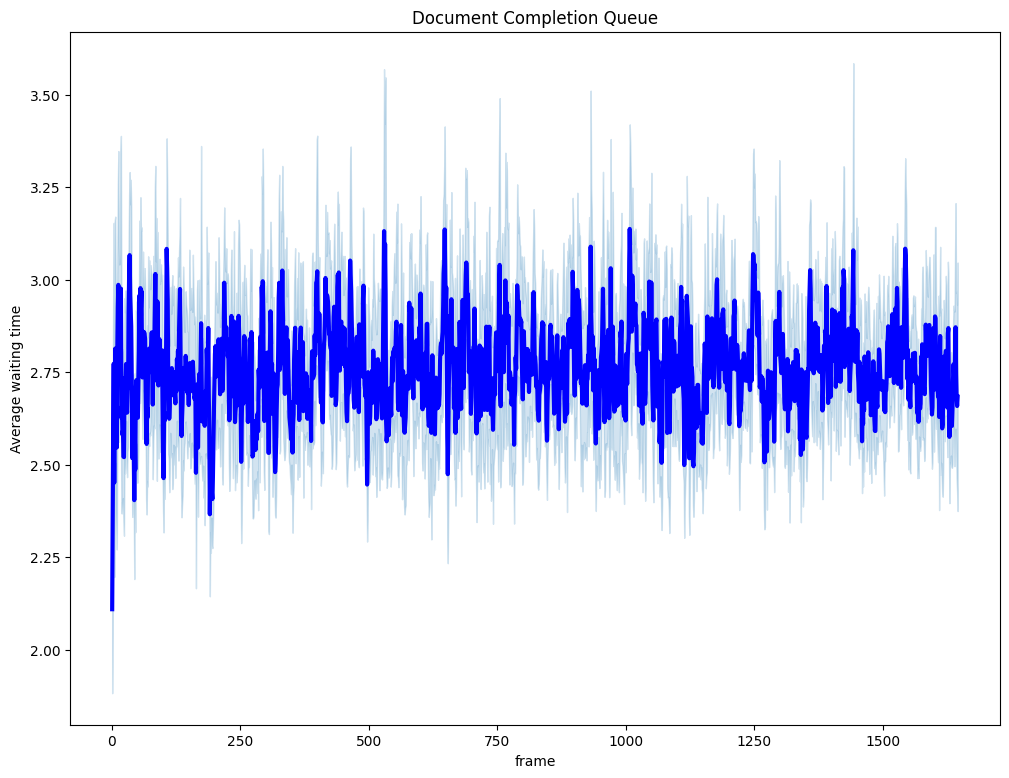

In [ ]:
warm_up_plot_waiting_time_in_que(q='Document Completion Queue',s='system1')


In [ ]:
df_Document_Completion_Queue =  df_warmup_analysis_wait.copy()


In [ ]:
df_Document_Completion_Queue_copy = df_Document_Completion_Queue.copy()


In [ ]:
filtered_df_Document_Completion_Queue = df_Document_Completion_Queue.iloc[151:] # deleting 151 frame for warm-up
mean_Document_Completion_Queue = filtered_df_Document_Completion_Queue.mean()


In [ ]:
L_Document_Completion_Queue_1 =list(mean_Document_Completion_Queue.head(20)) # data for 20 rep of  Document_Completion_Queue in system 1 after deleting warm-up data


In [ ]:
np.array(L_Document_Completion_Queue_1).mean() #average waiting time in Document_Completion_Queue

2.758555464347338

Document_Completion_Queue , system2

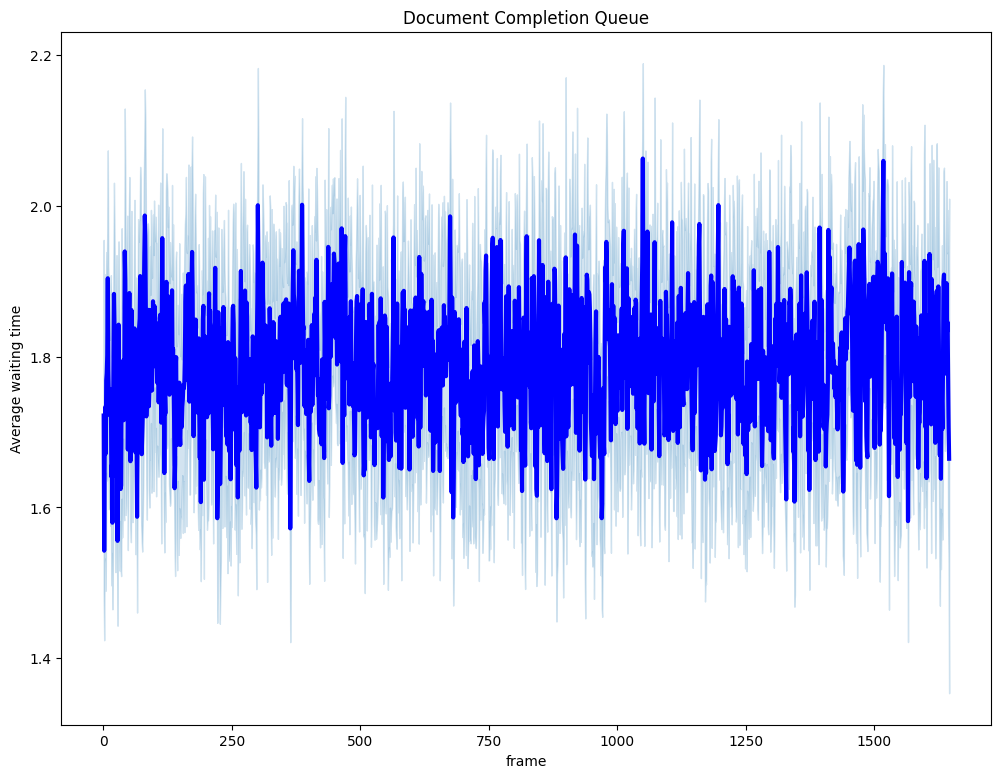

In [ ]:
warm_up_plot_waiting_time_in_que(q='Document Completion Queue',s='system2')

In [ ]:
df_Document_Completion_Queue2 =  df_warmup_analysis_wait.copy()

In [ ]:
df_Document_Completion_Queue_copy2 = df_Document_Completion_Queue2.copy()
filtered_df_Document_Completion_Queue2 = df_Document_Completion_Queue2.iloc[151:] # deleting 151 frame for warm-up
mean_Document_Completion_Queue2 = filtered_df_Document_Completion_Queue2.mean()

L_Document_Completion_Queue_2 =list(mean_Document_Completion_Queue2.head(20)) # data for 20 rep  in system 2 after deleting warm-up data

Document_formation_Queue , system1

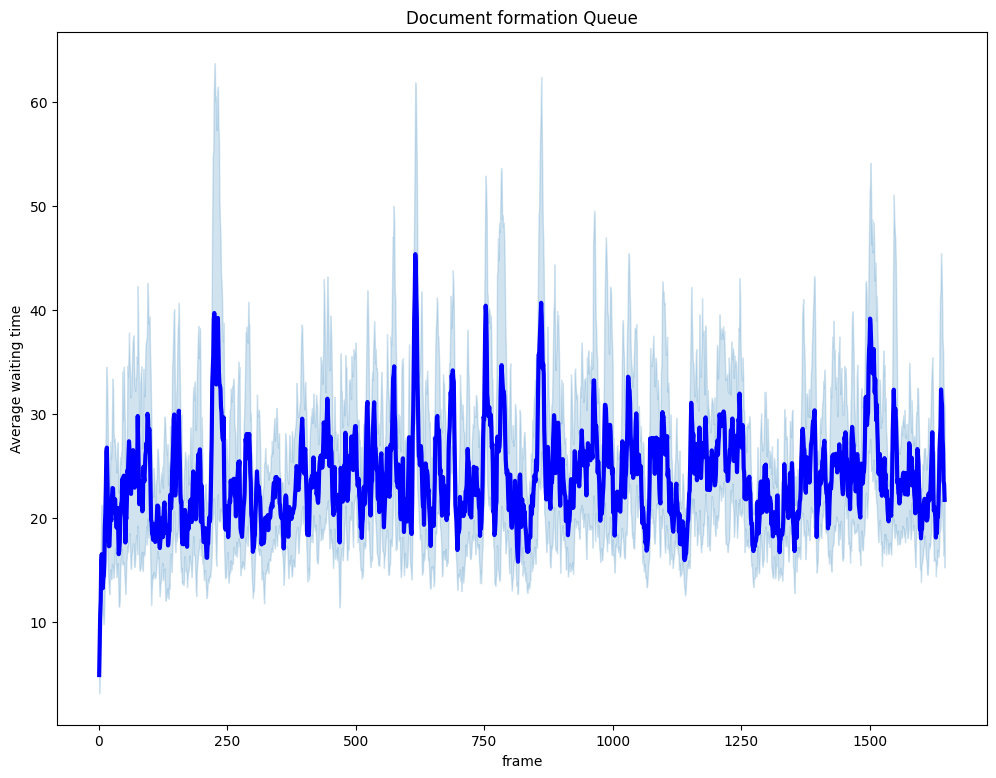

In [ ]:
warm_up_plot_waiting_time_in_que(q='Document formation Queue',s='system1')


In [ ]:
df_Document_formation_Queue =  df_warmup_analysis_wait.copy()


In [ ]:
df_Document_formation_Queue_copy = df_Document_formation_Queue.copy()


filtered_df_Document_formation_Queue = df_Document_formation_Queue.iloc[151:] # deleting 150 frame for warm-up
mean_Document_formation_Queue = filtered_df_Document_formation_Queue.mean()

L_Document_formation_Queue_1 =list(mean_Document_formation_Queue.head(20)) # data for 20 rep  in system 1 after deleting warm-up data


In [ ]:
np.array(L_Document_formation_Queue_1).mean() #average waiting time in formation_Completion_Queue

24.539667227214345

Document_formation_Queue , system2

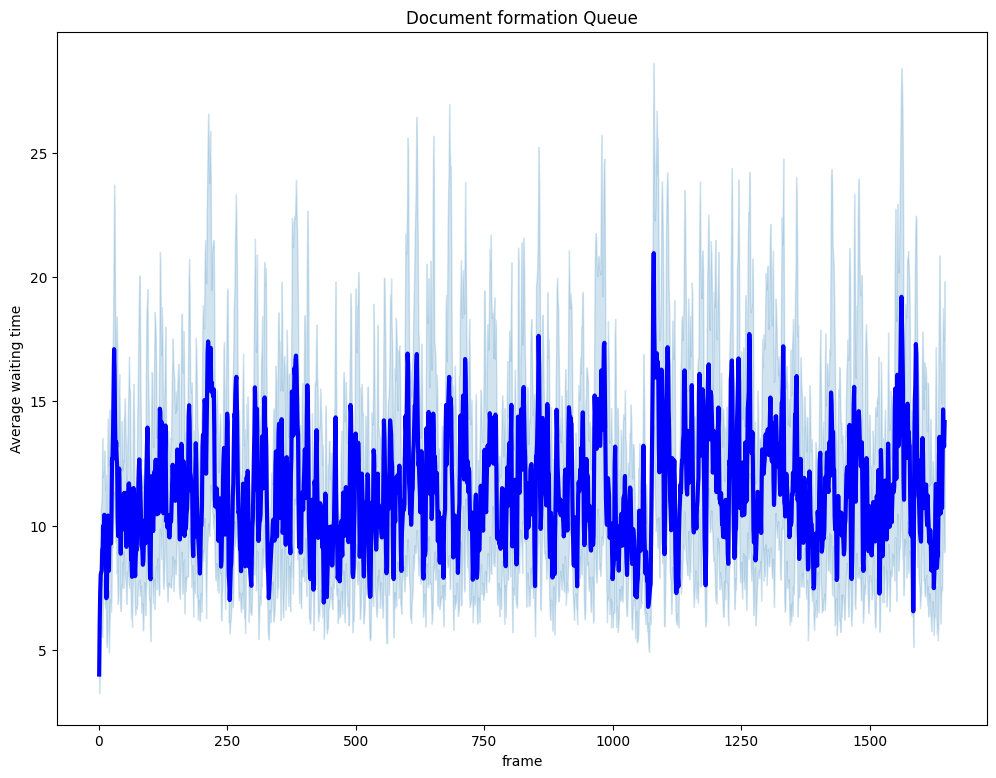

In [ ]:
warm_up_plot_waiting_time_in_que(q='Document formation Queue',s='system2')

In [ ]:
df_Document_formation_Queue2 =  df_warmup_analysis_wait.copy()

In [ ]:
df_Document_formation_Queue_copy2 = df_Document_formation_Queue2.copy()


filtered_df_Document_formation_Queue2 = df_Document_formation_Queue2.iloc[151:] # deleting 150 frame for warm-up
mean_Document_formation_Queue2 = filtered_df_Document_formation_Queue2.mean()

L_Document_formation_Queue_2 =list(mean_Document_formation_Queue2.head(20)) # data for 20 rep  in system 2 after deleting warm-up data


Photo Queue , system1

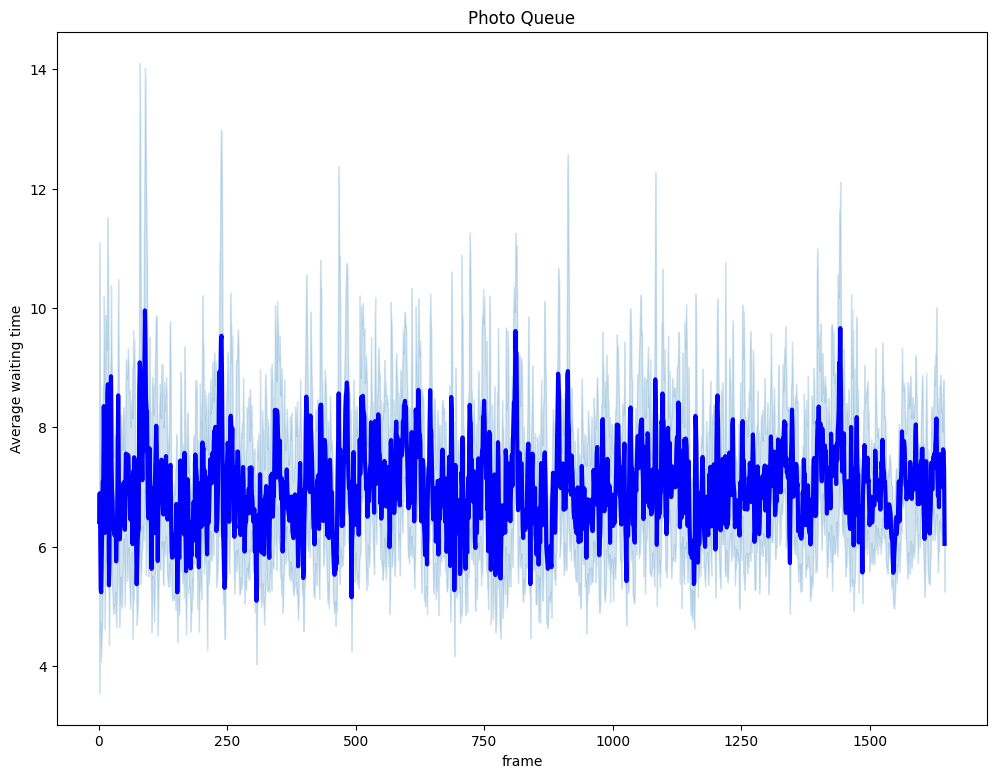

In [ ]:
warm_up_plot_waiting_time_in_que(q='Photo Queue',s='system1')

In [ ]:
df_photo_Queue =  df_warmup_analysis_wait.copy()

In [ ]:
df_photo_Queue_copy = df_photo_Queue.copy()


filtered_df_photo_Queue = df_photo_Queue.iloc[151:] # deleting 150 frame for warm-up
mean_photo_Queue = filtered_df_photo_Queue.mean()

L_photo_Queue_1 =list(mean_photo_Queue.head(20)) # data for 20 rep  in system 1 after deleting warm-up data

Photo Queue , system2

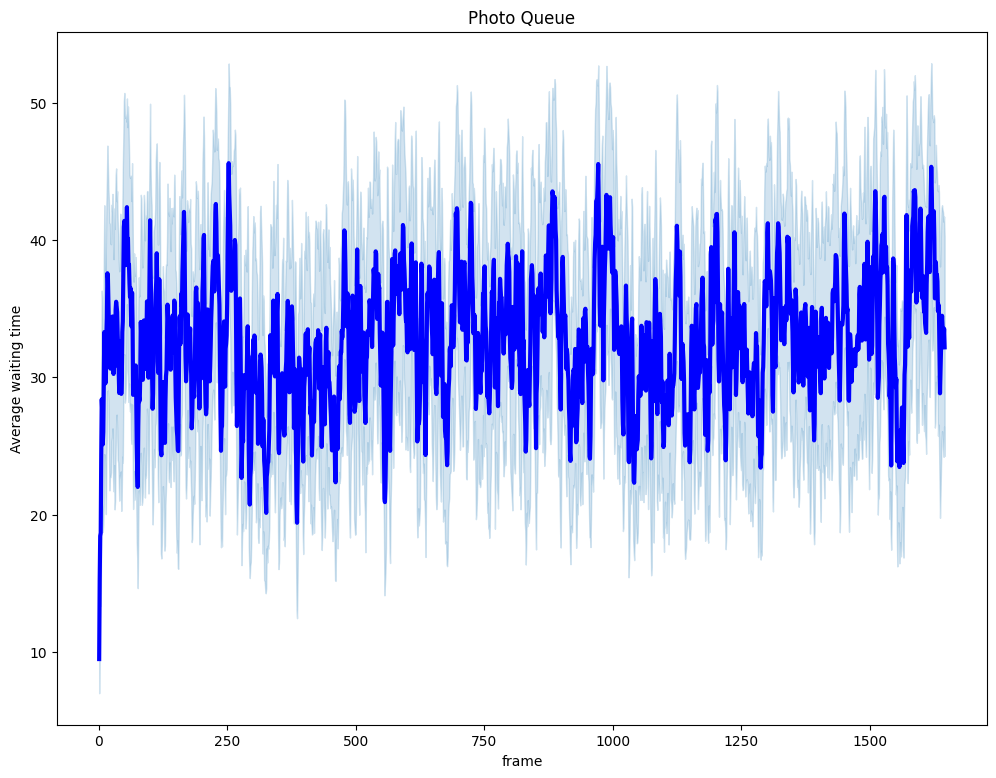

In [ ]:
warm_up_plot_waiting_time_in_que(q='Photo Queue',s='system2')

In [ ]:
df_photo_Queue2 =  df_warmup_analysis_wait.copy()

In [ ]:
df_photo_Queue_copy2 = df_photo_Queue2.copy()


filtered_df_photo_Queue2 = df_photo_Queue2.iloc[151:] # deleting 150 frame for warm-up
mean_photo_Queue2 = filtered_df_photo_Queue2.mean()

L_photo_Queue_2 =list(mean_photo_Queue2.head(20)) # data for 20 rep  in system 2 after deleting warm-up data

In [ ]:
L_photo_Queue_2

max formation Queue , system1

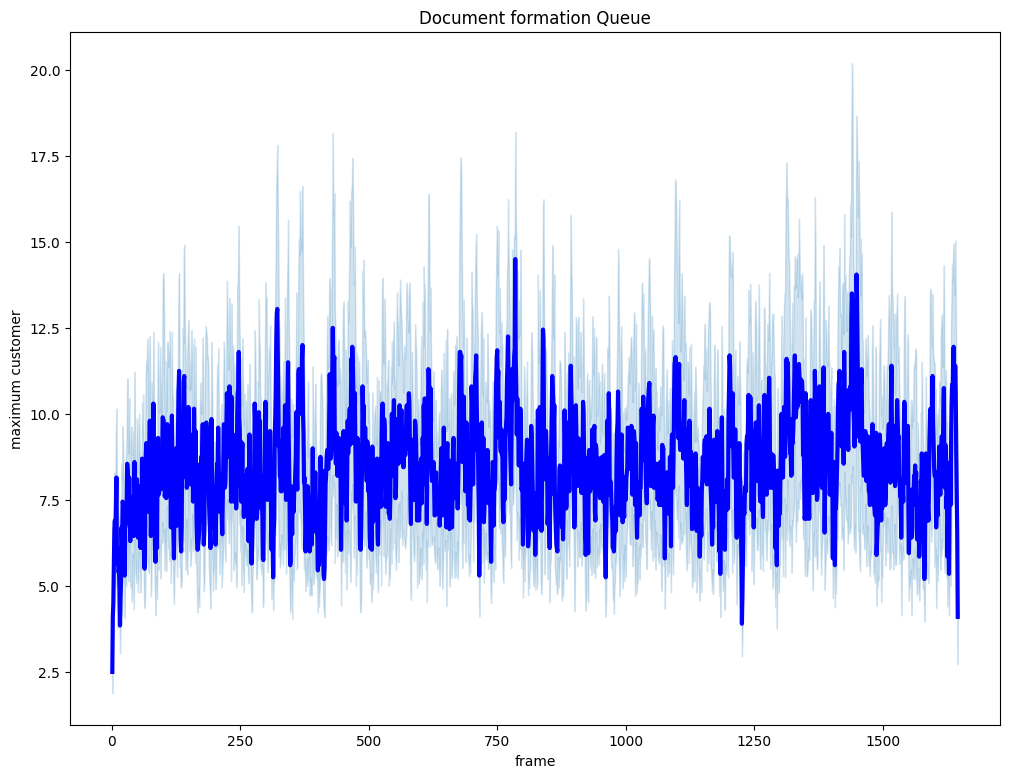

In [ ]:
warm_up_plot_max_in_que(q='Document formation Queue',s='system1')

In [ ]:
df_max_formation_Queue =  df_warmup_analysis_max.copy()

In [ ]:
df_max_formation_Queue_copy = df_max_formation_Queue.copy()


filtered_df_max_formation_Queue  = df_max_formation_Queue.iloc[151:] # deleting 150 frame for warm-up
mean_max_formation_Queue  = filtered_df_max_formation_Queue.mean()

L_max_formation_Queue_1 =list(mean_max_formation_Queue.head(20)) # data for 20 rep in system 1 after deleting warm-up data

max formation Queue , system2

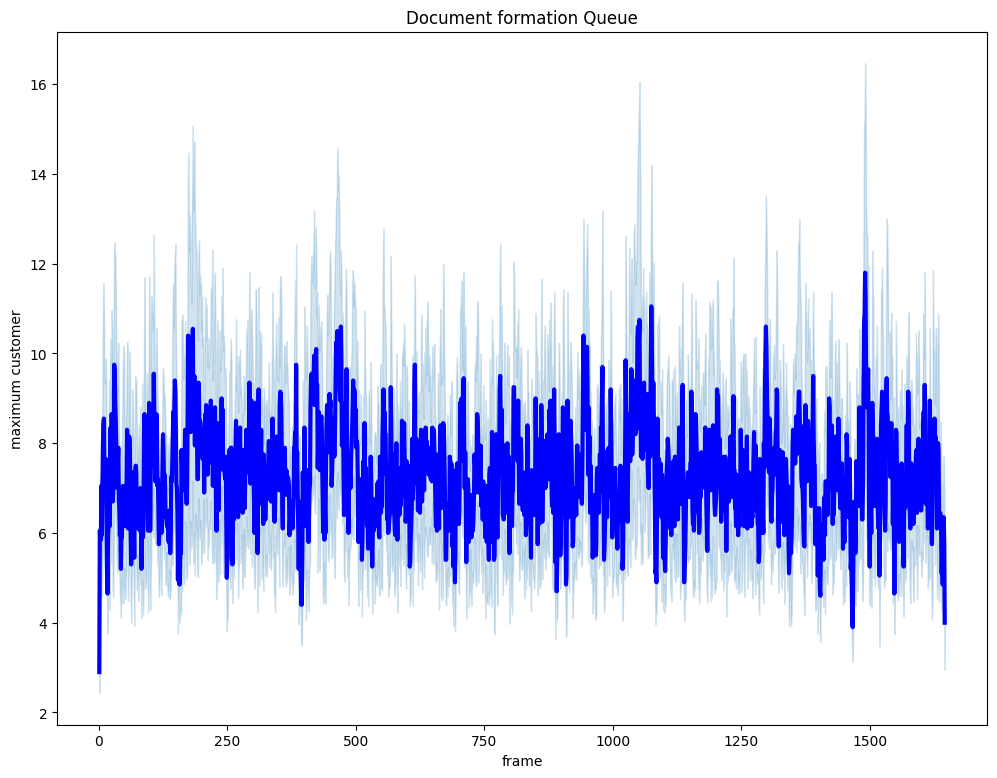

In [ ]:
warm_up_plot_max_in_que(q='Document formation Queue',s='system2')

In [ ]:
df_max_formation_Queue2 =  df_warmup_analysis_max.copy()

In [ ]:
df_max_formation_Queue_copy2 = df_max_formation_Queue2.copy()


filtered_df_max_formation_Queue2  = df_max_formation_Queue2.iloc[151:] # deleting 150 frame for warm-up
mean_max_formation_Queue2  = filtered_df_max_formation_Queue2.mean()

L_max_formation_Queue_2 =list(mean_max_formation_Queue2.head(20)) # data for 20 rep  in system 2 after deleting warm-up data

max completion Queue , system1

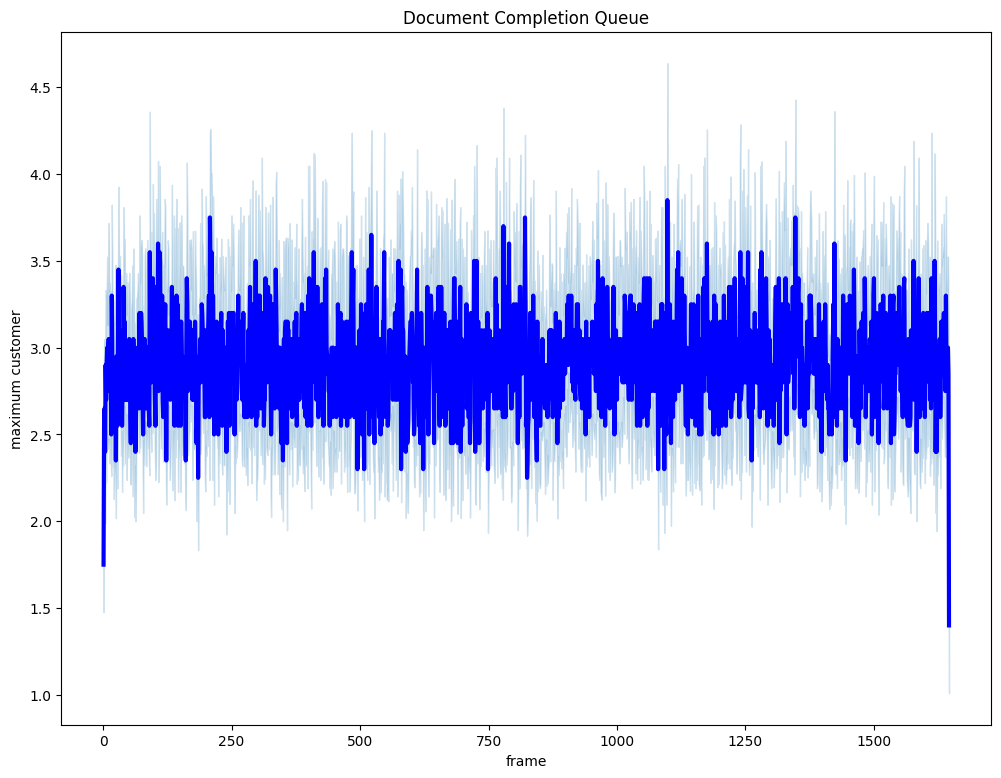

In [ ]:
warm_up_plot_max_in_que(q='Document Completion Queue',s='system1')

In [ ]:
df_max_Completion_Queue =  df_warmup_analysis_max.copy()

In [ ]:
df_max_Completion_Queue_copy = df_max_Completion_Queue.copy()


filtered_df_max_Completion_Queue  = df_max_Completion_Queue.iloc[151:] # deleting 150 frame for warm-up
mean_max_Completion_Queue  = filtered_df_max_Completion_Queue.mean()

L_max_Completion_Queue_1 =list(mean_max_Completion_Queue.head(20)) # data for 20 rep  in system 1 after deleting warm-up data

max completion Queue , system2

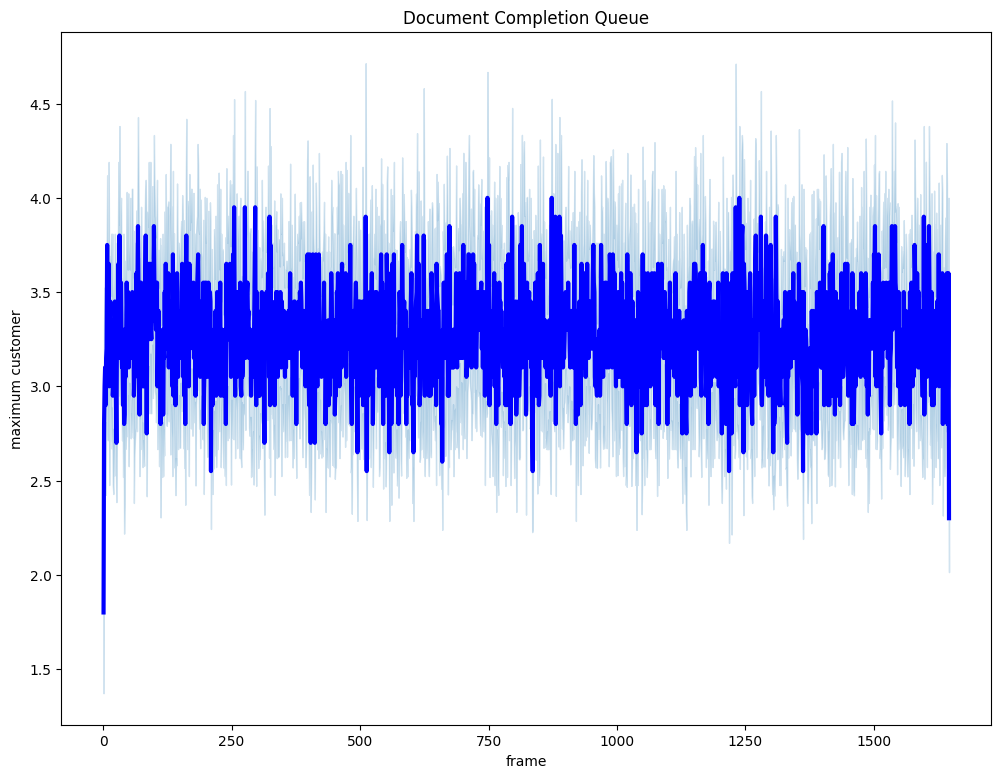

In [ ]:
warm_up_plot_max_in_que(q='Document Completion Queue',s='system2')

In [ ]:
df_max_Completion_Queue2 =  df_warmup_analysis_max.copy()

In [ ]:
df_max_Completion_Queue_copy2 = df_max_Completion_Queue2.copy()


filtered_df_max_Completion_Queue2  = df_max_Completion_Queue2.iloc[151:] # deleting 150 frame for warm-up
mean_max_Completion_Queue2  = filtered_df_max_Completion_Queue2.mean()

L_max_Completion_Queue_2 =list(mean_max_Completion_Queue2.head(20)) # data for 20 rep in system 2 after deleting warm-up data

 max Photo Queue , system 1

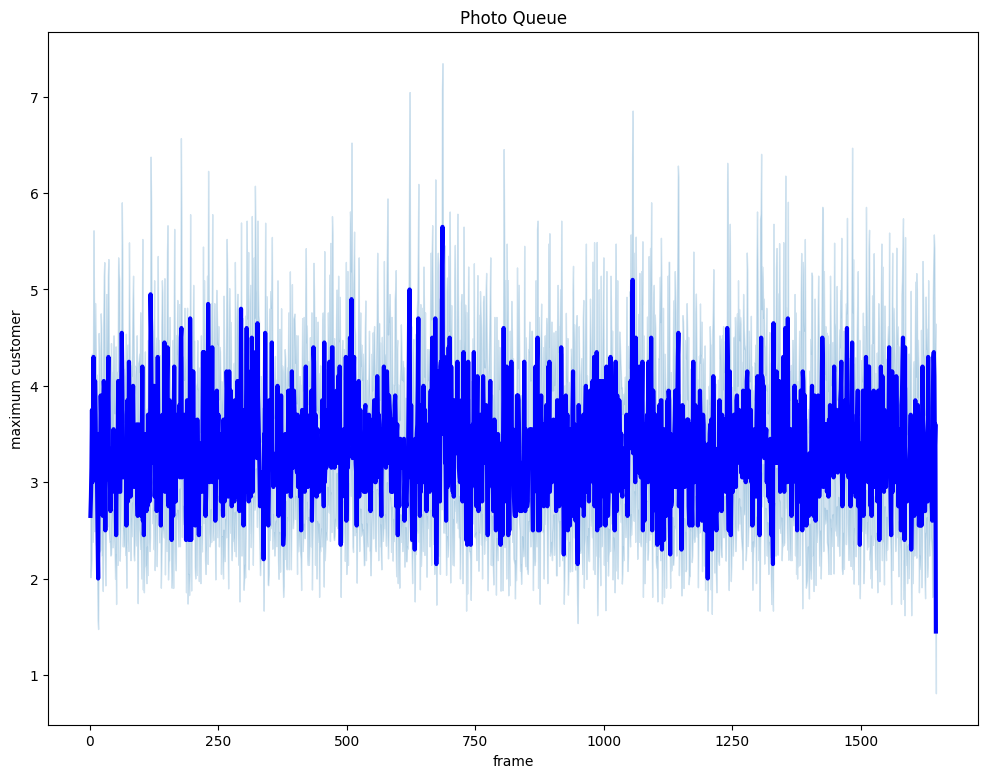

In [ ]:
warm_up_plot_max_in_que(q='Photo Queue',s='system1')

In [ ]:
df_max_Photo_Queue =  df_warmup_analysis_max.copy()

In [ ]:
df_max_Photo_Queue_copy = df_max_Photo_Queue.copy()


filtered_df_max_Photo_Queue  = df_max_Photo_Queue.iloc[151:] # deleting 150 frame for warm-up
mean_max_Photo_Queue  = filtered_df_max_Photo_Queue.mean()

L_max_Photo_Queue_1 =list(mean_max_Photo_Queue.head(20)) # data for 20 rep in system 1 after deleting warm-up data

max Photo Queue , system 2

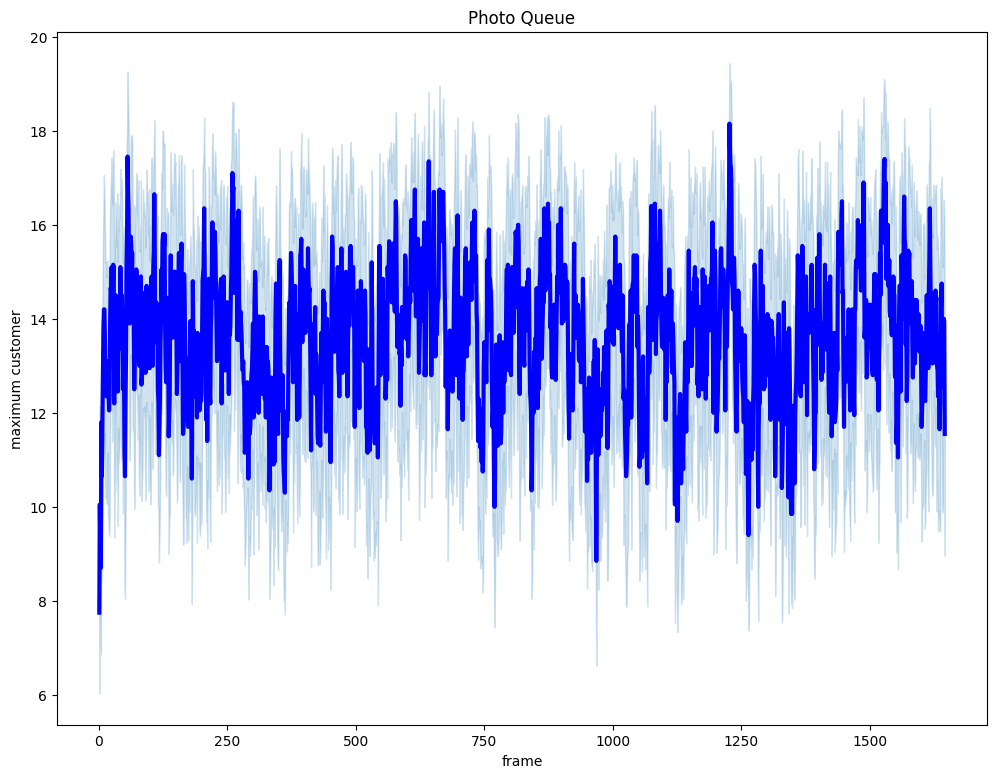

In [ ]:
warm_up_plot_max_in_que(q='Photo Queue',s='system2')

In [ ]:
df_max_Photo_Queue2 =  df_warmup_analysis_max.copy()

In [ ]:
df_max_Photo_Queue_copy2 = df_max_Photo_Queue2.copy()


filtered_df_max_Photo_Queue2  = df_max_Photo_Queue2.iloc[151:] # deleting 150 frame for warm-up
mean_max_Photo_Queue2  = filtered_df_max_Photo_Queue2.mean()

L_max_Photo_Queue_2 =list(mean_max_Photo_Queue2.head(20)) # data for 20 rep  in system 2 after deleting warm-up data

In [ ]:
L_max_Photo_Queue_1

The following function is designed to implement the independent sampling method for statistical tests

In [ ]:
def IR_sampleing(list_system1 , list_system2 , alpha  ):

  list_system1 = np.array(list_system1)
  list_system2 = np.array(list_system2)

  Y_bar_1 =list_system1.mean()
  Y_bar_2 =list_system2.mean()


  S1 = list_system1.std()
  S2 = list_system2.std()

  s_e = np.sqrt((S1**2)/len(list_system1) + (S2**2)/len(list_system2)) # S.E
  nu = ((S1**2/len(list_system1) + S2**2/len(list_system2))**2) / (S1**2/len(list_system1))**2/(len(list_system1) - 1) + (S2**2/len(list_system2))**2/(len(list_system2 - 1))  # Degree of freedom

  LB = Y_bar_1 - Y_bar_2  - stats.t.ppf(q=(1-alpha/2), df=np.ceil(nu)) * s_e  # CI lower bound
  UB = Y_bar_1 - Y_bar_2 + stats.t.ppf(q=(1-alpha/2), df=np.ceil(nu)) * s_e  # CI upper bound

  PE = 'Point Estimator: {0}'.format(( Y_bar_1 - Y_bar_2))  # Point estimator

   # Confidence interval estimator

  print(Y_bar_1 ,Y_bar_2 ,nu  , LB , UB , PE)
  # This if block is supposed to decide weather first system is better or not, and also print point and confidence interval estimation
  if (LB < 0) and (UB < 0):

      return "First system's configuration is better than the second system"
  elif (LB > 0) and (UB > 0):
      return "Second system's configuration is better than the first system"
  else:
      return "There is no significant difference between first and second system's configuration"



In [ ]:
IR_sampleing(list_system1= L_Document_Completion_Queue_1 , list_system2 =L_Document_Completion_Queue_2 , alpha=0.05)




2.758555464347338 1.782317874443391 0.06998295647021806 0.8739331654209593 1.0785420143869344 Point Estimator: 0.9762375899039468


"Second system's configuration is better than the first system"

In [ ]:
IR_sampleing(list_system1= L_Document_formation_Queue_1 , list_system2 =L_Document_formation_Queue_2 , alpha=0.05)

24.539667227214345 11.180857742225971 0.06092869675207363 4.9853282544905575 21.73229071548619 Point Estimator: 13.358809484988374


"Second system's configuration is better than the first system"

In [ ]:
IR_sampleing(list_system1= L_photo_Queue_1 , list_system2 =L_photo_Queue_2 , alpha=0.05)


7.056548285041456 32.22401825376985 143.3637428351351 -26.043190798122517 -24.29174913933427 Point Estimator: -25.167469968728394


"First system's configuration is better than the second system"

In [ ]:
IR_sampleing(list_system1= L_max_formation_Queue_1 , list_system2 =L_max_formation_Queue_2 , alpha=0.05)

8.556889632107024 7.320200668896321 0.0903651329956615 -0.46459065563486646 2.937968582056273 Point Estimator: 1.2366889632107032


"There is no significant difference between first and second system's configuration"

In [ ]:
IR_sampleing(list_system1= L_max_Completion_Queue_1 , list_system2 =L_max_Completion_Queue_2 , alpha=0.05)

2.9169230769230774 3.263478260869565 0.16543655153813489 -0.4696804695164256 -0.2234298983765499 Point Estimator: -0.34655518394648777


"First system's configuration is better than the second system"

In [ ]:
IR_sampleing(list_system1= L_max_Photo_Queue_1 , list_system2 =L_max_Photo_Queue_2 , alpha=0.05)

3.3492976588628762 13.58107023411371 160.4043538380359 -10.398553706234901 -10.064991444266765 Point Estimator: -10.231772575250833


"First system's configuration is better than the second system"